# Predicting Future Hourly Sales 
## By John-Edward Ferreira

This prohject will use historical time series sales and foot traffic data to ultimately make predictions about hourly sales for the following month.

To begin with we will familiarise oursleves with the data to see what we are working with, how far back does our data go? How many entries are there? Is our data concentrated over period or is it consistent over the entire time period.

We will also be exploring the data by looking for outliers. We will assess these as well as missing values to determine how to handle them. Also, as part of our exploratory data analysis we will look for trends or relationships between the different time measures (days, weeks, months, time of day, year) to assess if there are obvious relationships between sales and foot traffic and these different factors of time. Once we identify correlations or relationships we can then start to construct the features of our model in order to make future predictions.

## Data Familiarity 

What we will do is first deconstruct our data, which at the moment consists only of a date and time stamp and related hourly sales. Once we do this we can start to become acquantied with our data. Once we can hypothesize as to relationships between times/days/months etc we can begin to understand what features or correlations we can featurize to generate optimal predictive power in our model. Some of the more obvious assumptions could be that sales increase on weekends and closer to Christmas, there may be peak hours in the day where traffic and sales are at their highest.

Once we have done this we can look closer at our data, deciding on features, deciding what to keep and what to get rid of. We can also look into external data that can fruther promote predictive power in our model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 

import warnings
warnings.filterwarnings('ignore')

sales = pd.read_csv('training_Sales.csv')

traffic = pd.read_csv('training_Traffic.csv')

In [2]:
sales.columns = ['date', 'value']
traffic.columns = ['date', 'value']

sales['date'] = pd.to_datetime(sales['date'])
traffic['date'] = pd.to_datetime(traffic['date'])

In [3]:
print('The date range of the data for sales is ' + str(sales['date'].dt.date.min()) + ' to ' + str(sales['date'].dt.date.max()))
print()
print('The date range of the data for foot traffic is ' + str(traffic['date'].dt.date.min()) + ' to ' + str(traffic['date'].dt.date.max()))

The date range of the data for sales is 2013-11-07 to 2018-05-06

The date range of the data for foot traffic is 2015-01-01 to 2018-05-06


## Notes on Datasets

As can be seen, our data for traffic and sales do not cover the same time periods. We have no data from before the start of 2015 for traffic, however, we have sales data going back as far as November 2013.

The missing data in Traffic may not be a problem. Once we have set up models and determined if we can accurately predict traffic going forward we can make further deliberations. If our model is adequate we need do nothing, if not we can always impute the missing values for Traffic (in terms of the timeline we have in sales) and we can use our Sales values to impute these values.

## Datetime

Let's decompress our datetime into bit size column seperations:

In [4]:
sales['year'] = sales['date'].dt.year ## Getting year only for traffic and sales
traffic['year'] = traffic['date'].dt.year

sales['month'] = sales['date'].dt.month_name() ## Getting month no. and month name only for traffic and sales
traffic['month'] = traffic['date'].dt.month_name()
sales['month_no'] = sales['date'].dt.month
traffic['month_no'] = traffic['date'].dt.month

sales['day'] = sales['date'].dt.day_name() ## getting day name only for traffic and sales
traffic['day'] = traffic['date'].dt.day_name()

sales['day_no'] = sales['date'].dt.day ## getting day no. for traffic and sales and converting to int
traffic['day_no'] = traffic['date'].dt.day
sales['day_no'] = sales['day_no'].astype(int)
traffic['day_no'] = traffic['day_no'].astype(int)

sales['time'] = sales['date'].dt.strftime('%H') ## Getting hour in question of timestamp for sales and traffic
traffic['time'] = traffic['date'].dt.strftime('%H')

sales['day_month'] = sales['date'].dt.strftime('%d %B')
traffic['day_month'] = traffic['date'].dt.strftime('%d %B')

sales.head(3)


,date,value,year,month,month_no,day,day_no,time,day_month
0,2013-11-07 13:00:00,830,2013,November,11,Thursday,7,13,07 November
1,2013-11-07 13:15:00,885,2013,November,11,Thursday,7,13,07 November
2,2013-11-07 13:30:00,938,2013,November,11,Thursday,7,13,07 November


In [5]:
traffic['year'].value_counts()

2016    17587
2017    17462
2015    17422
2018     5966
Name: year, dtype: int64

In [6]:
sales['year'].value_counts()

2017    15094
2016    15089
2015    15000
2014    14295
2018     5245
2013     2335
Name: year, dtype: int64

In [7]:
sales[sales['year'] == 2013]['month'].value_counts()

December    1423
November     912
Name: month, dtype: int64

## Distribution and Outliers

Let's take a look at the distribution of our sales and traffic. In doing so we can identify and investigate outliers and determine if they will go some way in making our model generalise well, or if we they are anomalies that can be removed.

Whilst outliers are not necessarily bad for our model, as they help our model generalise better on unseen data, if they are extreme we do run the chance that they will distort our model and may be suboptimal in so far as they contribute to the predictive power of our model.

Therefore, it is good to retain some outliers and remove some that are very extreme. The best course of action is to create a threshold, identify outliers outside of this threshold and investigate them to determine if they should be retained or removed.

## Sales

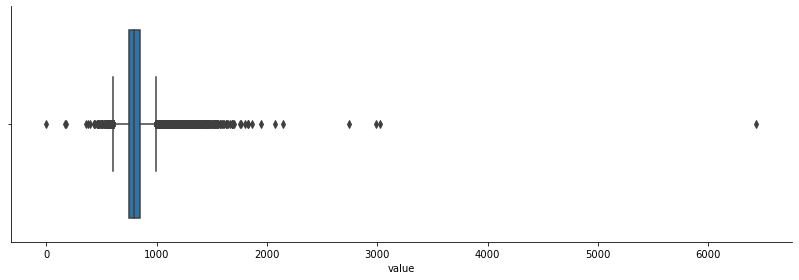

In [8]:
sns.catplot(x = 'value', kind = 'box', height = 4, aspect = 2.8, data = sales)

We will investigate the outliers with more than value = 2000 for our sales dataset:

In [9]:
sales[sales['value'] > 3000]

,date,value,year,month,month_no,day,day_no,time,day_month
26396,2015-08-29 14:00:00,3027,2015,August,8,Saturday,29,14,29 August
54468,2017-07-09 19:15:00,6435,2017,July,7,Sunday,9,19,09 July


Looking at the results of our outliers there are some that seem obvious:

- For the instance of the 31st of December, we know this to be New years Eve and as such may expect the higher sales volume.
- However, the high sale for the 23rd of January seems like an anomaly.
- July 9th: Although this is quite close to the popular American Independance Day which is on the 4th of July, it does seem still like quite the outlier. This is because it wouldn't be a holiday as it is many days from the 4th.
- The outliers/sales for June, August and April both seem arbitrary as they do not fall anywhere near public holidays. Nor is there any evidence that there is a trend of high sales volumes on these days thorughout different years. In fact there are no distinguishing features to support the higher than usual sales volumes on these days. As such they will be removed from the dataset.

As such we will be dropping the outliers for the following month instances:

- January
- April
- June
- July
- August

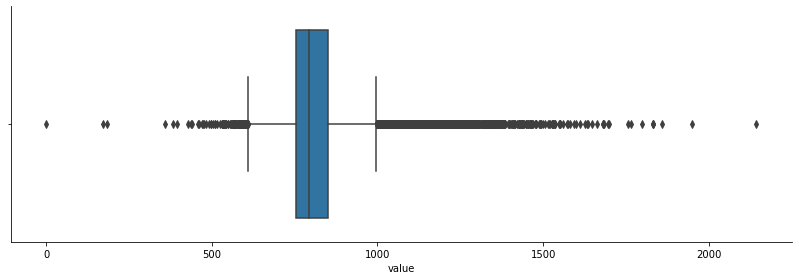

In [10]:
sales = sales[sales['value'] < 2145]
sales = sales[sales['value'] != 2075]

sns.catplot(x = 'value', kind = 'box', height = 4, aspect = 2.8, data = sales)

Our distribution now looks much more reasonable.

## Traffic

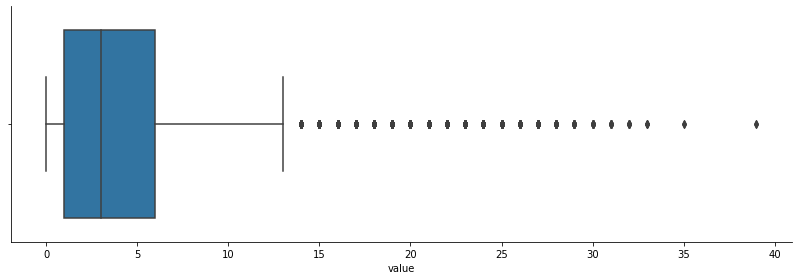

In [11]:
sns.catplot(x = 'value', kind = 'box', height = 4, aspect = 2.8, data = traffic)

We will arbitrarily choose a value = 25 as the threshold of outliers for traffic

In [12]:
traffic_outliers = traffic[traffic['value'] > 25]

traffic_outliers['year'].value_counts()

2016    48
2015    47
2017    43
Name: year, dtype: int64

These outliers seem quite evenly distributed across the different years in the dataset implying that they this kind of value action is a trend year on year.

In [13]:
traffic_outliers['month'].value_counts()

December    88
November    48
January      2
Name: month, dtype: int64

**JANUARY**

In [14]:
traffic_outliers[traffic_outliers['month'] == 'January']

,date,value,year,month,month_no,day,day_no,time,day_month
109,2015-01-03 13:45:00,26,2015,January,1,Saturday,3,13,03 January
17490,2016-01-02 16:15:00,28,2016,January,1,Saturday,2,16,02 January


Here we see consistently high traffic for practically the same period over the years 2015 and 2016. Which means that we could say it is a trend, or at least there is definitely evidence to suggest that high traffic is to be expected at this time of January every year - the first weekend of January right after New Years Day. Therefore we will keep these data points.

**NOVEMBER**

In [15]:
traffic_outliers[traffic_outliers['month'] == 'November']['year'].value_counts()

2016    20
2017    15
2015    13
Name: year, dtype: int64

In [16]:
traffic_outliers[traffic_outliers['month'] == 'November']['day'].value_counts()

Friday      47
Saturday     1
Name: day, dtype: int64

In [17]:
traffic_outliers[traffic_outliers['month'] == 'November']['day_no'].value_counts()

25    19
24    15
27    13
26     1
Name: day_no, dtype: int64

We know that Thanksgiving is in November (on the fourth Thursday) and as such would expect high traffic volumes around this time (The weekend thereafter included) - which seems evident in the above data. We will keep these data points.

**DECEMBER**

In [18]:
traffic_outliers[traffic_outliers['month'] == 'December']['day_no'].value_counts()

26    37
23    14
27    11
20     6
22     6
17     5
21     4
19     3
11     1
16     1
Name: day_no, dtype: int64

We will begin by disregarding the data points that are around Christmas as we would expect higher traffic volumes around this time:

In [19]:
traffic_outliers[(traffic_outliers['month'] == 'December') & (traffic_outliers['day_no'] <21)]

,date,value,year,month,month_no,day,day_no,time,day_month
16768,2015-12-19 14:15:00,28,2015,December,12,Saturday,19,14,19 December
16769,2015-12-19 14:30:00,27,2015,December,12,Saturday,19,14,19 December
16773,2015-12-19 15:30:00,29,2015,December,12,Saturday,19,15,19 December
16827,2015-12-20 13:00:00,27,2015,December,12,Sunday,20,13,20 December
16829,2015-12-20 13:30:00,26,2015,December,12,Sunday,20,13,20 December
16832,2015-12-20 14:15:00,29,2015,December,12,Sunday,20,14,20 December
16835,2015-12-20 15:00:00,27,2015,December,12,Sunday,20,15,20 December
16838,2015-12-20 15:45:00,27,2015,December,12,Sunday,20,15,20 December
16839,2015-12-20 16:00:00,30,2015,December,12,Sunday,20,16,20 December
33871,2016-12-11 13:45:00,27,2016,December,12,Sunday,11,13,11 December


Looking at the data directly above, there does not seem to be any reason as to why these data points should be removed. All these data points occur on weekends in December across differenty years. Therefore this data will go further in optimizing our model to predict accurately - we will keep it.

Looking at the trends we can see in the data thus far, one would believe the shop in question to be either a grocery store store, or a liqour store; certainly some kind of retail store - all significant outliers seem to be on public holidays and weekends. 

## Organising Data Into Hourly Sales

Now that we have identified and removed extreme points in our data, we can begin by getting our data into the format for which we will be training our model. Once in this format we can explore the data to determine relationships over time across data points such as day, time of day, time of month, month and year.

Firt we will resample our data so it is in the format of total sales per hour across time. We can then identify missing elements in the data and decide how to rectify these data points. We will drop all added columns for the time being, resample the data, reapply the datetime format across the columns, then assess the data.


In [20]:
sales.drop(['year', 'month', 'month_no', 'day',
            'day_no', 'time', 'day_month'], inplace = True, axis = 1)

traffic.drop(['year', 'month', 'month_no', 'day',
            'day_no', 'time', 'day_month'], inplace = True, axis = 1)

In [21]:
sales = sales.set_index('date')
sales = sales.resample('1H').sum()
sales.reset_index(inplace = True)

sales.head(5)

,date,value
0,2013-11-07 13:00:00,3457
1,2013-11-07 14:00:00,2250
2,2013-11-07 15:00:00,0
3,2013-11-07 16:00:00,729
4,2013-11-07 17:00:00,0


In [22]:
traffic = traffic.set_index('date')
traffic = traffic.resample('1H').sum()
traffic.reset_index(inplace = True)

traffic.head(5)

,date,value
0,2015-01-01 10:00:00,8
1,2015-01-01 11:00:00,14
2,2015-01-01 12:00:00,28
3,2015-01-01 13:00:00,33
4,2015-01-01 14:00:00,47


Let's reapply some of the column decompartmentalisations for better optics on the data and for both data exploration and feature construction later on.

In [23]:
sales['year'] = sales['date'].dt.year ## Getting year only for traffic and sales
traffic['year'] = traffic['date'].dt.year

sales['month'] = sales['date'].dt.month_name() ## Getting month name for traffic and sales
traffic['month'] = traffic['date'].dt.month_name()

sales['day_no'] = sales['date'].dt.day ## getting day no. for traffic and sales and converting to int
traffic['day_no'] = traffic['date'].dt.day
sales['day'] = sales['date'].dt.day_name()
traffic['day'] = traffic['date'].dt.day_name()

sales['time'] = sales['date'].dt.strftime('%H') ## Getting hour in question of timestamp for sales and traffic
traffic['time'] = traffic['date'].dt.strftime('%H')

sales['day_month'] = sales['date'].dt.strftime('%d %B')
traffic['day_month'] = traffic['date'].dt.strftime('%d %B')


Now that our data is in the workable format we want. We can look at the missing/zero values:

In [24]:
sales.isnull().sum()

date         0
value        0
year         0
month        0
day_no       0
day          0
time         0
day_month    0
dtype: int64

In [25]:
traffic.isnull().sum()

date         0
value        0
year         0
month        0
day_no       0
day          0
time         0
day_month    0
dtype: int64

There do not appear to be any null or NaN values. Although as we can see below there are many hours for which there are no sales - this is not surprising and is to be expected in any many kinds of retail shops.

## Federal Public Holidays

What we have extablished however is that there may be a relationship between sales/traffic and public holidays and weekends. This makes sense for any retail operation. We already have feratures to determine if the day is a weekend or not, but have not accounted for or given any description for days that are public holidays. We will now add a column to this effect.


- New Year's Day: **January 1st**
- Martin Luther King, Jr. Day: **Every Third Monday In January**
- George Washington’s Birthday: **Every Third Monday in February**
- Memorial Day: **Every Fourth Monday in May**
- Independence Day: **4th July**
- Labor Day: **First Monday September** 
- Columbus Day: **Every Second Monday of October**
- Veterans Day: **11th November**
- Thanksgiving Day: **Fourth Thursday of Every November**
- Christmas Day: **25th December**


We will make a function and create a new column in our traffic and sales datasets for public holidays where 'yes' will mean it is public holiday and where 'no' will mean it isn't a public holiday. 

Unfortunately due to the nature of public holidays not always occuring on specific dates, our function may be slightly long and tiresome to capture the difference in dates for thes public holidays across the years in our dataset.

Further to this, seeing as Christmas is a day normally spent at home with family, and saeeing as there were such high sales and traffic volumes around this time (as seen above), we will use the 24th and the 26th of December as 'public holidays' to account for this holiday. We will do this as opposed to creating an entire column to account for 'christmas holiday time'. In this way we should achieve the same effect and highlight these data points as being around this holiday time - so that our model can at a later stage take this into account when making predictions.

SOURCE: https://www.public-holidays.us/US_BG_2018_Federal%20holidays

In [26]:
def public_holidays(series_year, series_day_month): ##Function for returning a yes in a different column                               ##if day in question is a public holiday
    if series_year == 2013:
        if series_day_month == '01 January':
            return 'yes'
        elif series_day_month == '21 January':
            return 'yes'
        elif series_day_month == '18 February':
            return 'yes'
        elif series_day_month == '27 May':
            return 'yes'
        elif series_day_month == '04 July':
            return 'yes'
        elif series_day_month == '02 September':
            return 'yes'
        elif series_day_month == '14 October':
            return 'yes'
        elif series_day_month == '11 November':
            return 'yes'
        elif series_day_month == '28 November':
            return 'yes'
        elif series_day_month == '24 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        elif series_day_month == '26 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        else:
            return 'no'
    
    elif series_year == 2014:
        if series_day_month == '01 January':
            return 'yes'
        elif series_day_month == '20 January':
            return 'yes'
        elif series_day_month == '17 February':
            return 'yes'
        elif series_day_month == '26 May':
            return 'yes'
        elif series_day_month == '04 July':
            return 'yes'
        elif series_day_month == '01 September':
            return 'yes'
        elif series_day_month == '13 October':
            return 'yes'
        elif series_day_month == '11 November':
            return 'yes'
        elif series_day_month == '27 November':
            return 'yes'
        elif series_day_month == '24 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        elif series_day_month == '26 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        else:
            return 'no'
    
    elif series_year == 2015:
        if series_day_month == '01 January':
            return 'yes'
        elif series_day_month == '19 January':
            return 'yes'
        elif series_day_month == '16 February':
            return 'yes'
        elif series_day_month == '25 May':
            return 'yes'
        elif series_day_month == '03 July':
            return 'yes'
        elif series_day_month == '07 September':
            return 'yes'
        elif series_day_month == '12 October':
            return 'yes'
        elif series_day_month == '11 November':
            return 'yes'
        elif series_day_month == '26 November':
            return 'yes'
        elif series_day_month == '24 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        elif series_day_month == '26 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        else:
            return 'no'
    
    elif series_year == 2016:
        if series_day_month == '01 January':
            return 'yes'
        elif series_day_month == '18 January':
            return 'yes'
        elif series_day_month == '15 February':
            return 'yes'
        elif series_day_month == '30 May':
            return 'yes'
        elif series_day_month == '04 July':
            return 'yes'
        elif series_day_month == '05 September':
            return 'yes'
        elif series_day_month == '10 October':
            return 'yes'
        elif series_day_month == '11 November':
            return 'yes'
        elif series_day_month == '24 November':
            return 'yes'
        elif series_day_month == '24 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        elif series_day_month == '26 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        else:
            return 'no'
    
    elif series_year == 2017:
        if series_day_month == '02 January':
            return 'yes'
        elif series_day_month == '16 January':
            return 'yes'
        elif series_day_month == '20 February':
            return 'yes'
        elif series_day_month == '29 May':
            return 'yes'
        elif series_day_month == '04 July':
            return 'yes'
        elif series_day_month == '04 September':
            return 'yes'
        elif series_day_month == '09 October':
            return 'yes'
        elif series_day_month == '10 November':
            return 'yes'
        elif series_day_month == '23 November':
            return 'yes'
        elif series_day_month == '24 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        elif series_day_month == '26 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        else:
            return 'no'
    
    elif series_year == 2018:
        if series_day_month == '01 January':
            return 'yes'
        elif series_day_month == '15 January':
            return 'yes'
        elif series_day_month == '19 February':
            return 'yes'
        elif series_day_month == '28 May':
            return 'yes'
        elif series_day_month == '04 July':
            return 'yes'
        elif series_day_month == '03 September':
            return 'yes'
        elif series_day_month == '08 October':
            return 'yes'
        elif series_day_month == '12 November':
            return 'yes'
        elif series_day_month == '22 November':
            return 'yes'
        elif series_day_month == '24 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        elif series_day_month == '26 December': ## Accounting for 'holiday like spending' around christmas
            return 'yes'
        else:
            return 'no'
    
    

    
def day_cat(day_no): ##Function for assigning a time of month into three categories:
    if day_no <= 10:
        return 'Month Beginning'
    elif 10 < day_no <= 20:
        return 'Mid Month'
    else:
        return "Month End"
    

        

In [27]:
sales['public_holiday?'] = sales.apply(lambda x: public_holidays(x['year'], x['day_month']), axis=1)
traffic['public_holiday?'] = traffic.apply(lambda x: public_holidays(x['year'], x['day_month']), axis=1)

sales['month_cat'] = sales['day_no'].apply(day_cat)
traffic['month_cat'] = traffic['day_no'].apply(day_cat)

## Charting Possible Relationships

First we will chart the relationship between sales and traffic - one would expexct this to be positive and proportional: more traffic more sales and vice versa.

After that, now that we have made our data more granular in terms of time/date/day etc. We can chart sales and traffic against these time points to see if there are any trends. Once we identify trends we will begin to understand the relationships between time as fragments and sales and traffic eg: the relationship between day of the week and sales, or time of the month and sales, or even time of the day and sales. Once we see that relationships exist we can begin to decide on features to add to our training data.

## Sales vs Traffic

Text(0.5, 0.98, 'Traffic Through Time')

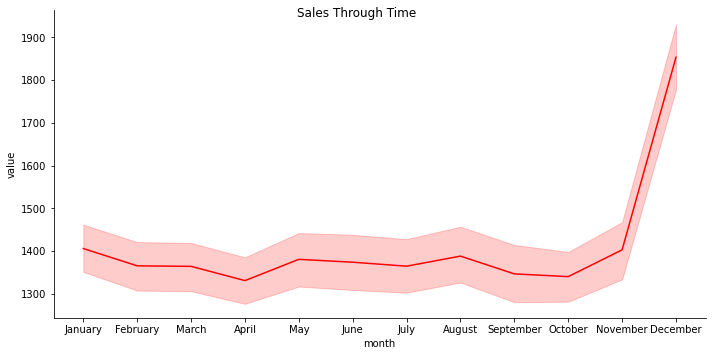

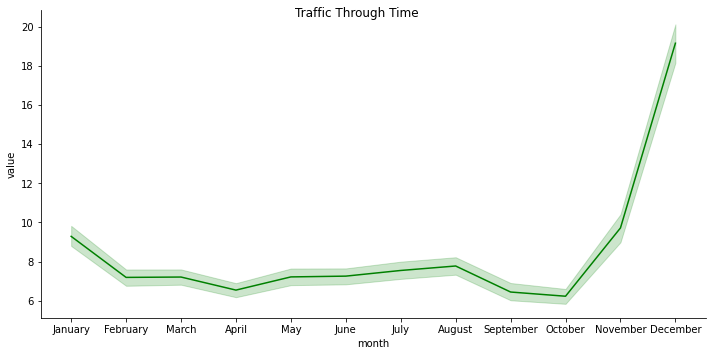

In [28]:
%matplotlib inline 

## To make it easier to compare to traffic we will use sales data that does not have data
## from the years 2013 and 2014 - as is the case with the traffic data

same_timeline_sales = sales[(sales['year'] != 2013) & (sales['year'] != 2014)] 

ax = sns.relplot(x = 'month', y = 'value',
                data = same_timeline_sales, kind = 'line', aspect = 2, height = 5, color = 'red')

ax1 = sns.relplot(x = 'month', y = 'value',
                data = traffic, kind = 'line', aspect = 2, height = 5, color = 'green')


ax.fig.suptitle('Sales Through Time', fontsize = 12)
ax1.fig.suptitle('Traffic Through Time', fontsize = 12)



Although the months in question over the time period of the two datasets (traffic and sales) are not in the correct order, the purpose of the exercise was to satisfy the hypothesis that sales and traffic are directly correlated with one another- which the above chart demonstrates. We can clearly see that sales and traffic tend to move in unison with one another for the most part. 

**We could potentially include our predicted traffic in our training for sales to help make our sales predictions more accurate.**

## Total Sales Through Time

Let's take a look at the total sales across all the months of the year for the years in which we have data in both datasets (sales and traffic). Looking at this should help us identify trends year on year - which could go a long way in helping us make predictions for the following month.

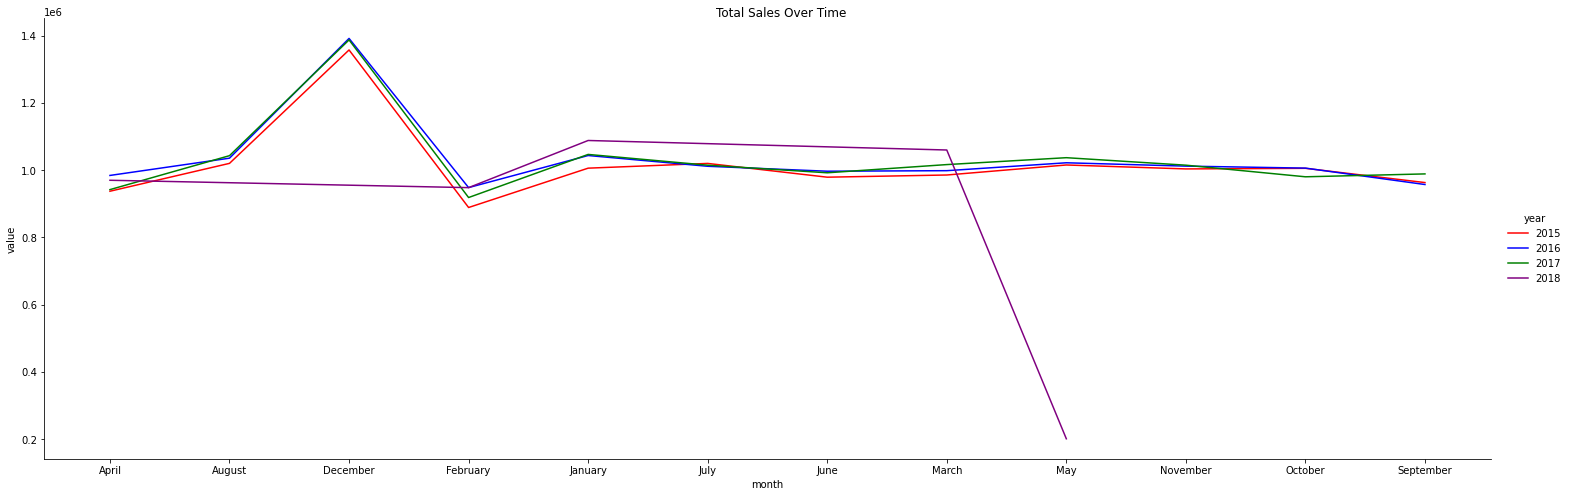

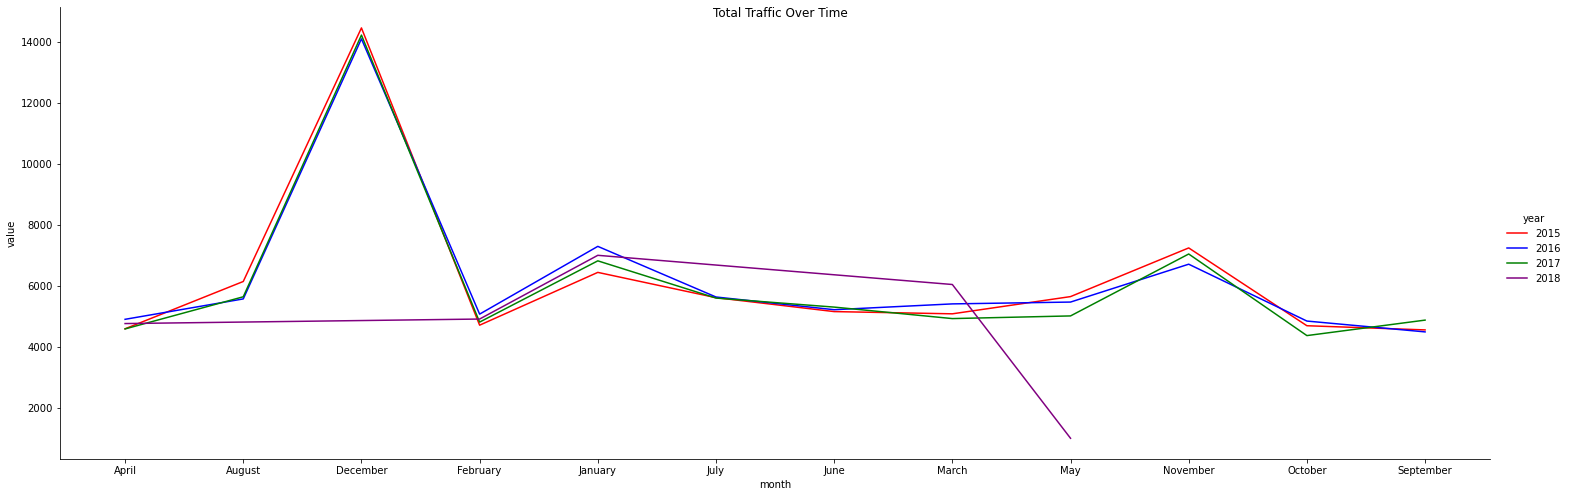

In [29]:
sales_m_y = same_timeline_sales.groupby(['month', 'year'], as_index = False)['value'].sum()
traffic_m_y = traffic.groupby(['month', 'year'], as_index = False)['value'].sum()


ax1 = sns.relplot(x = 'month', y = 'value', hue = 'year',
                data = sales_m_y, kind = 'line', aspect = 3, height = 7,
                palette = ['red', 'blue', 'green', 'purple'])


ax2 = sns.relplot(x = 'month', y = 'value', hue = 'year',
                data = traffic_m_y, kind = 'line', aspect = 3, height = 7,
                palette = ['red', 'blue', 'green', 'purple'])

ax1.fig.suptitle('Total Sales Over Time', fontsize = 12)
ax2.fig.suptitle('Total Traffic Over Time', fontsize = 12)
    

plt.show()


Looking at the above charts we see that trends in both traffic and sales seem to prevail year after year in a simialr fashion for the most part. This should make our resuilts easier to predict as it seems that sales and traffic magnitudes are nearly identical year on year. 

A piece of information worth noting is that both sales and traffic seem to be higher than previous years for 2018 from the month of February. 

## Sales and Traffic By Time Segmentations

We will now chart sales and traffic by time segments to see how time of the day, day of the week, time of the month and time of the year relate to both traffic and sales. Once we have established some trends/evidence of a possible relationship, we will be able to begin engineering some features for our model.

In [30]:
month_order = ['January', 'February', 'March','April', 'May', 'June','July',
              'August', 'September', 'October', 'November', 'December']

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

time_order = ['07', '08', '09', '10', '11', '12', '13', '14','15', '16','17', '18', '19',
              '20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06']


time_of_month_order = ['Month Beginning', 'Mid Month', 'Month End']

## Sales

year_sales = sales.groupby(['year'], as_index = False)['value'].mean().round(2)
month_sales = sales.groupby(['year','month'], as_index = False)['value'].mean().round(2)
time_of_month_sales = sales.groupby(['year','month_cat'], as_index = False)['value'].mean().round(2)
day_sales = sales.groupby(['year','day'], as_index = False)['value'].mean().round(2)
time_sales = sales.groupby(['year','time'], as_index = False)['value'].mean().round(2)



month_sales['month'] = pd.Categorical(month_sales['month'], categories = month_order, ordered = True)
day_sales['day'] = pd.Categorical(day_sales['day'], categories = day_order, ordered = True)
time_sales['time'] = pd.Categorical(time_sales['time'], categories = time_order, ordered = True)
time_of_month_sales['month_cat'] = pd.Categorical(time_of_month_sales['month_cat'], categories = time_of_month_order,
                                     ordered = True)


month_sales.sort_values('month', inplace = True)
day_sales.sort_values('day', inplace = True)
time_sales.sort_values('time', inplace = True)
time_of_month_sales.sort_values('month_cat', inplace = True)


## Traffic


year_traffic = traffic.groupby(['year'], as_index = False)['value'].mean().round(2)
month_traffic = traffic.groupby(['year','month'], as_index = False)['value'].mean().round(2)
time_of_month_traffic = traffic.groupby(['year','month_cat'], as_index = False)['value'].mean().round(2)
day_traffic = traffic.groupby(['year','day'], as_index = False)['value'].mean().round(2)
time_traffic = traffic.groupby(['year','time'], as_index = False)['value'].mean().round(2)


month_traffic['month'] = pd.Categorical(month_traffic['month'], categories = month_order, ordered = True)
day_traffic['day'] = pd.Categorical(day_traffic['day'], categories = day_order, ordered = True)
time_traffic['time'] = pd.Categorical(time_traffic['time'], categories = time_order, ordered = True)
time_of_month_traffic['month_cat'] = pd.Categorical(time_of_month_traffic['month_cat'], categories = time_of_month_order,
                                     ordered = True)


month_traffic.sort_values('month', inplace = True)
day_traffic.sort_values('day', inplace = True)
time_traffic.sort_values('time', inplace = True)
time_of_month_traffic.sort_values('month_cat', inplace = True)


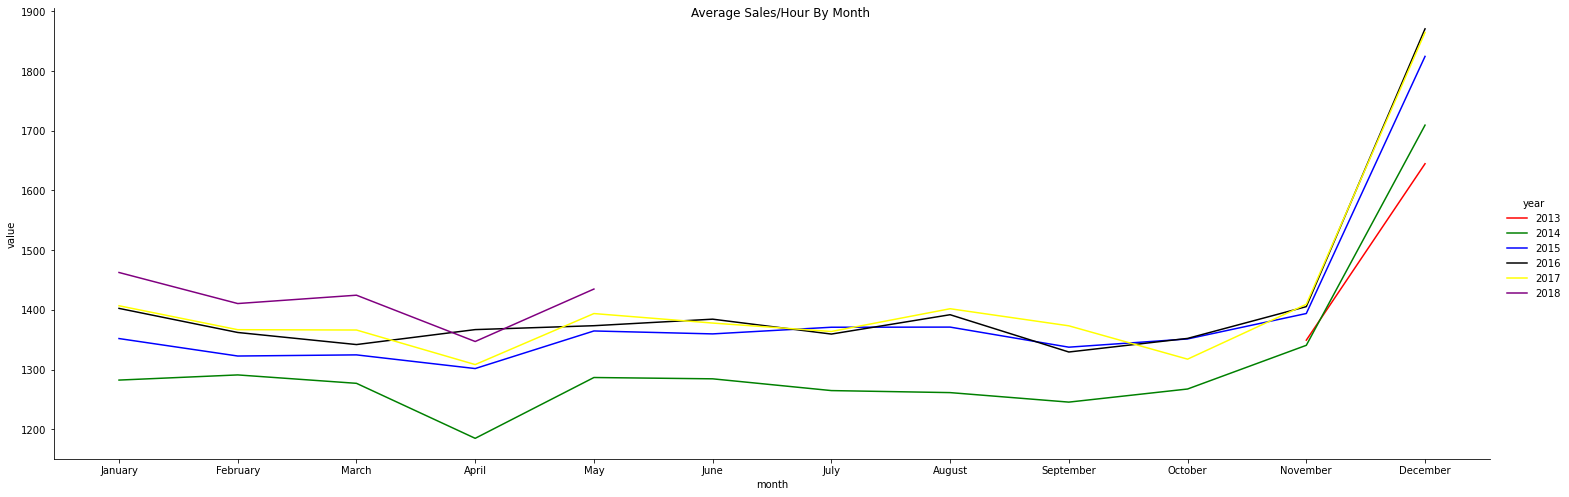

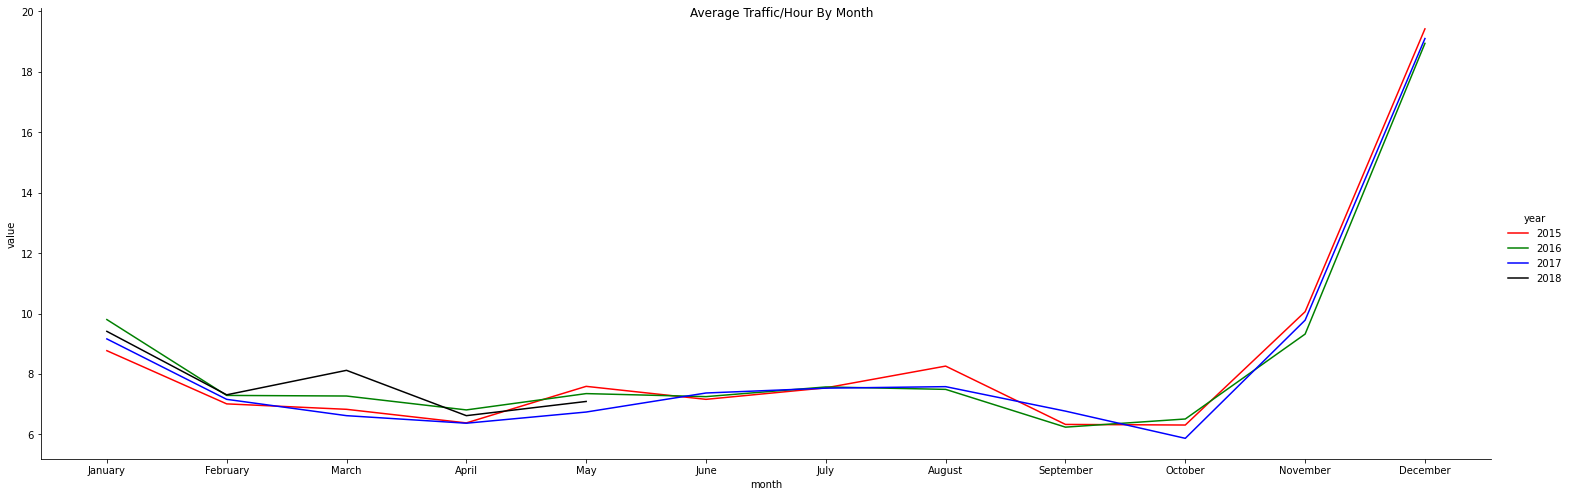

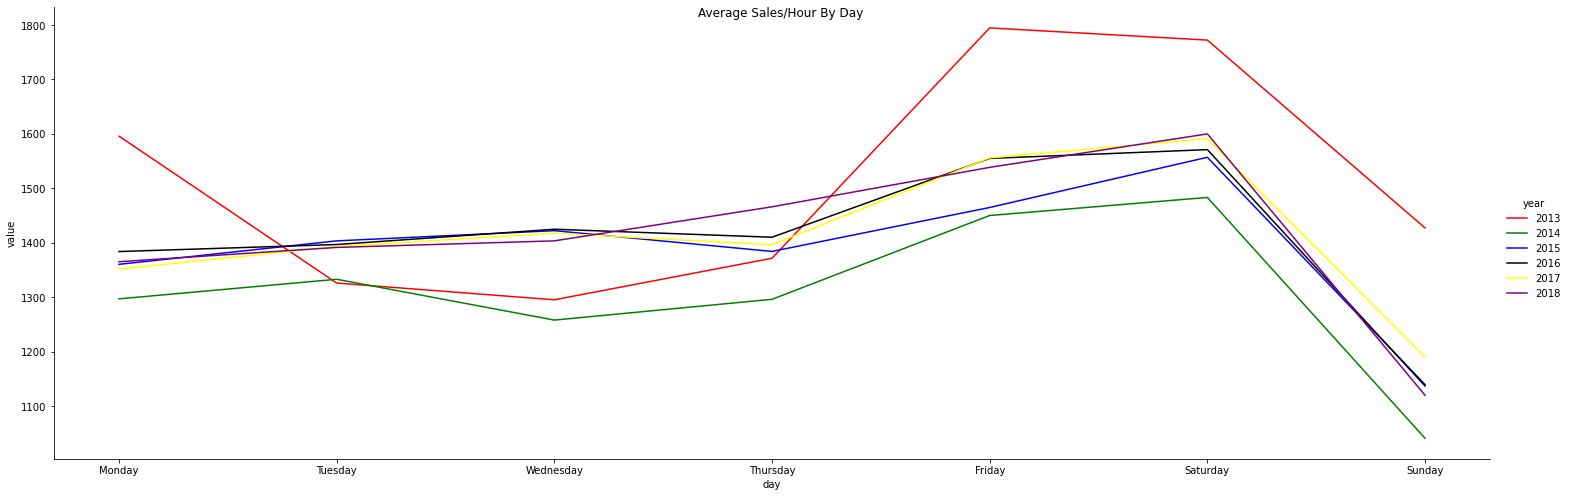

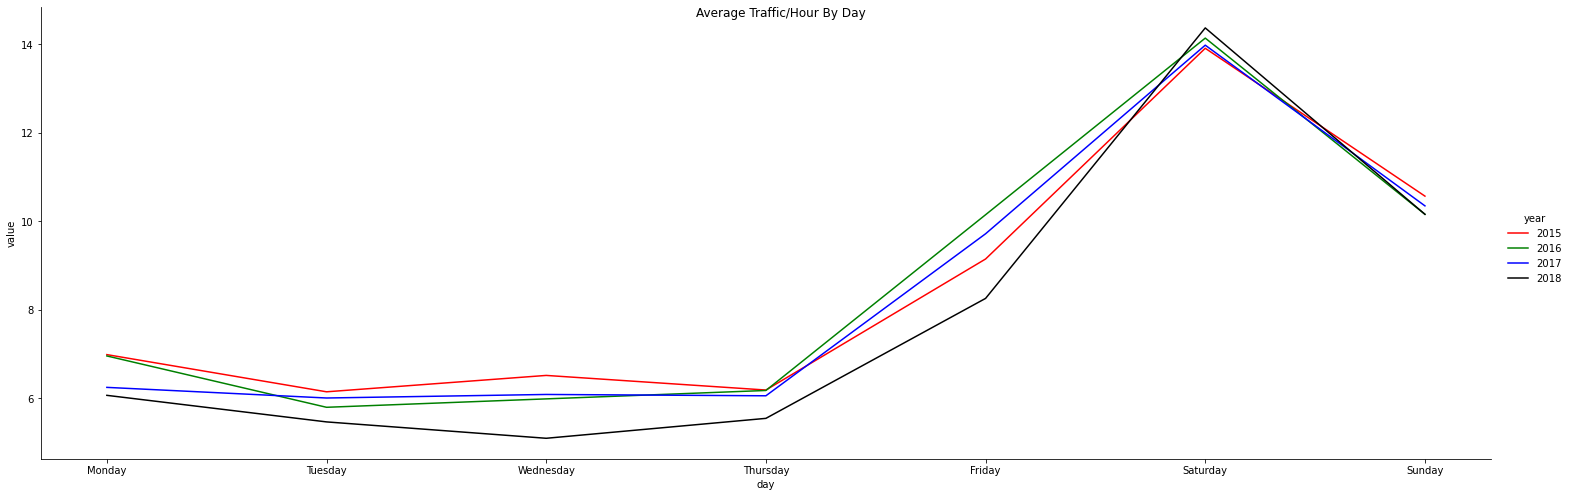

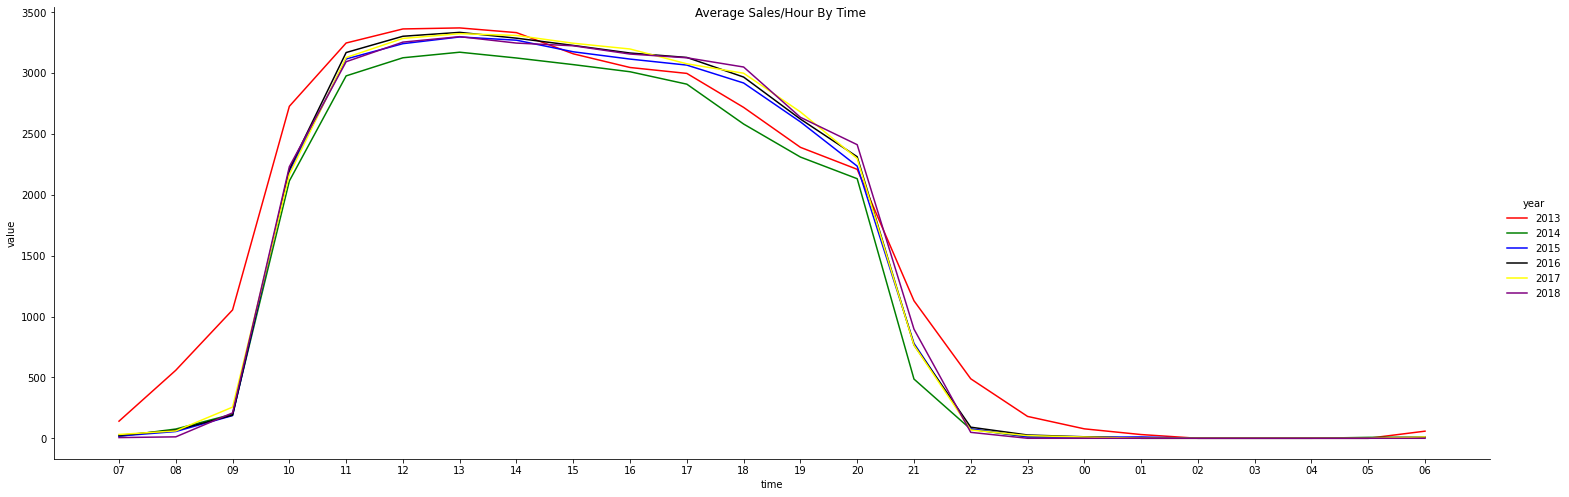

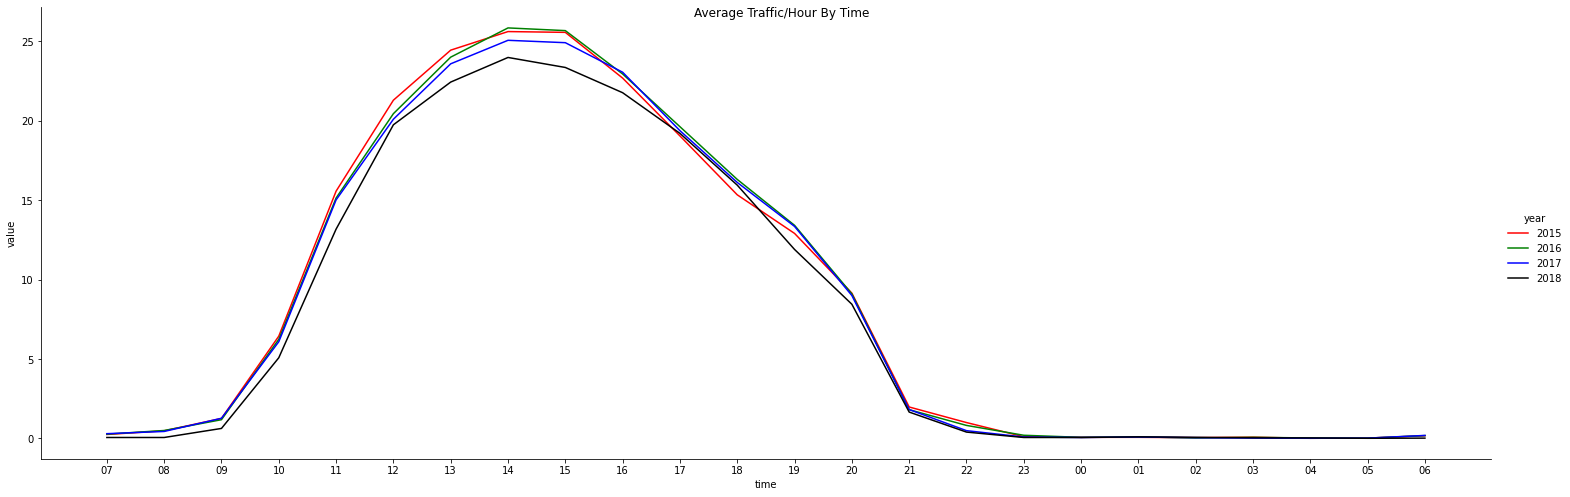

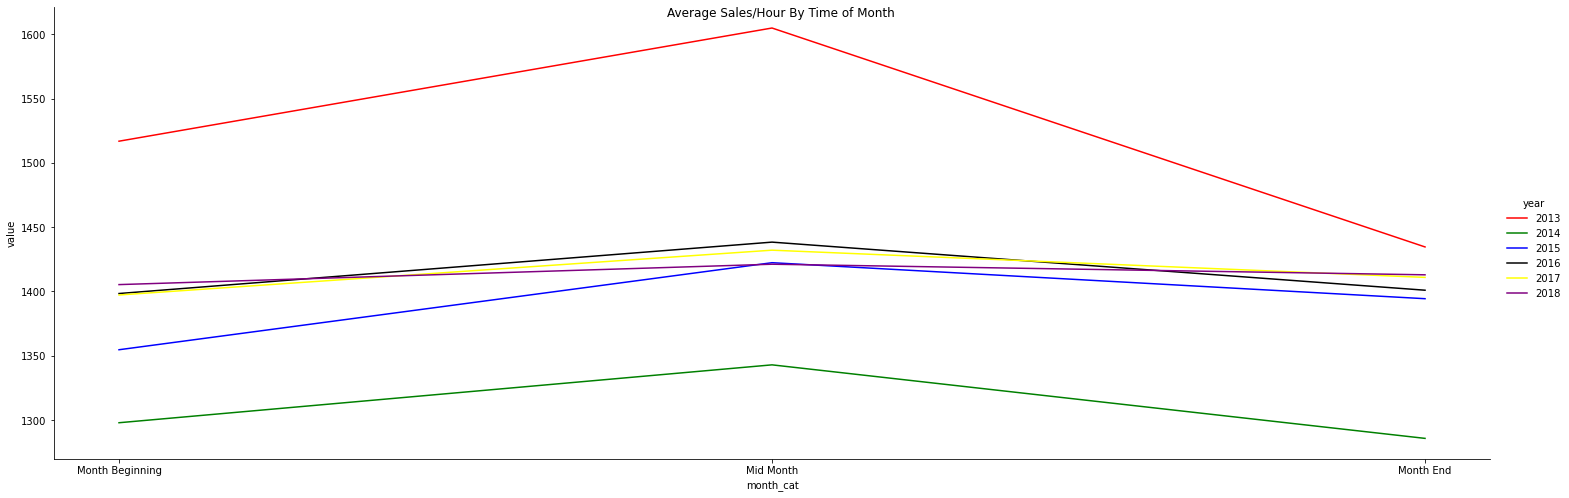

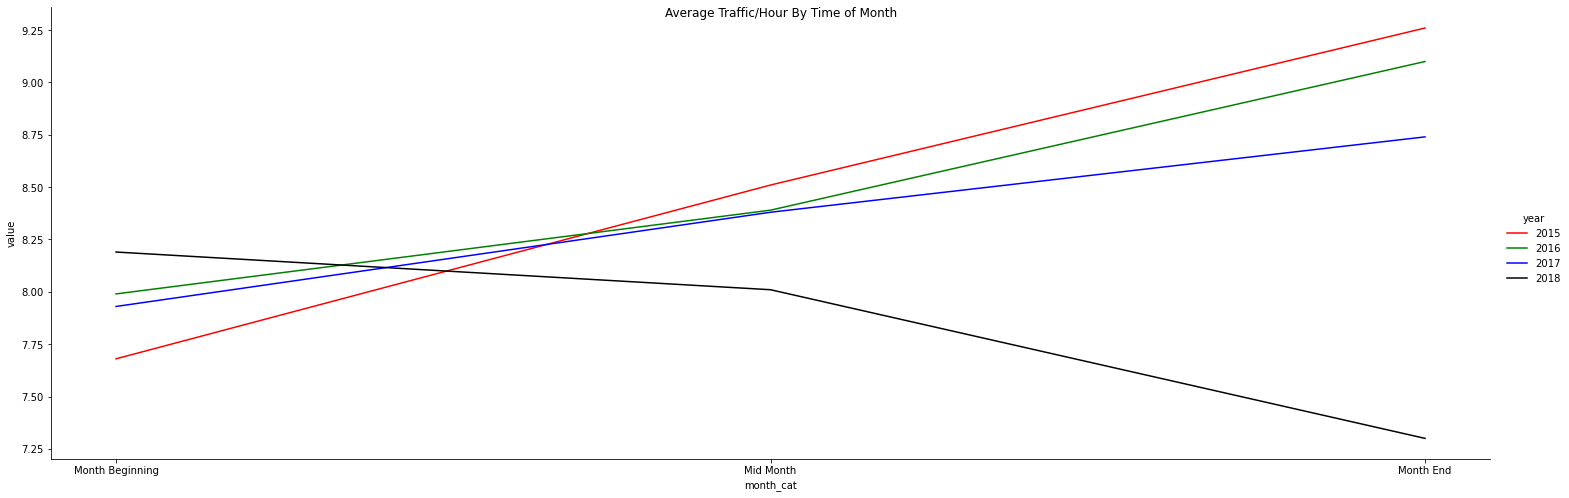

In [31]:
sales_charts = [month_sales, day_sales, time_sales, time_of_month_sales]
traffic_charts = [month_traffic, day_traffic, time_traffic, time_of_month_traffic]

s_titles = ['Average Sales/Hour By Month',
          'Average Sales/Hour By Day', 'Average Sales/Hour By Time',
          'Average Sales/Hour By Time of Month']

t_titles = ['Average Traffic/Hour By Month',
          'Average Traffic/Hour By Day', 'Average Traffic/Hour By Time',
          'Average Traffic/Hour By Time of Month']


for s_chart, t_chart, s_title, t_title in zip(sales_charts, traffic_charts, s_titles, t_titles):
    ax = sns.relplot(x = s_chart.columns[1], y = s_chart.columns[2], hue = 'year',
                data = s_chart, kind = 'line', aspect = 3, height = 7, palette = ['red', 'green', 'blue', 'black', 'yellow', 'purple'])
    ax1 = sns.relplot(x = s_chart.columns[1], y = t_chart.columns[2], hue = 'year',
                data = t_chart, kind = 'line', aspect = 3, height = 7, palette = ['red', 'green', 'blue', 'black'])
    
    ax.fig.suptitle(s_title, fontsize = 12)
    ax1.fig.suptitle(t_title, fontsize = 12)
    
    plt.show()
  



## Distribution

[Text(0.5, 0, 'Value/Hour'), Text(0, 0.5, 'Count')]

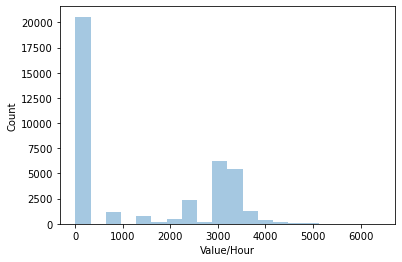

In [32]:
sns.distplot(sales['value'], norm_hist = False, kde = False, bins = 20).set(xlabel = 'Value/Hour', ylabel = 'Count')

It looks like our data is being skewed by the amount of hours with zero sales. These tend to be the hours of between 01 and 04 for which there are no sales whatsoever. It may be worth dropping these instances entirely to avoid skewing of our data. However, leaving them as zero will also add to such dates in the future also being predicted as zero. So for now we will in all likelihood go ahead and train with the zero's and should our results not be satisfactory we will revert back this and drop these instances. Other than the large amount of 0's our distribution seems to be farely normal.

We will make a seperate dataset right now for the purpose of removing these clsoing hours at a later stage:

In [33]:
sales_chi = sales.copy() ## chi: closing hours included
traffic_chi = traffic.copy()

## Seasonality and Trend: Sales and Traffic

In [34]:
import statsmodels.api as sm

sales_for_decompose = sales[['date','value']]
traffic_for_decompose = traffic[['date', 'value']]

sales_for_decompose = sales_for_decompose.set_index('date')
traffic_for_decompose = traffic_for_decompose.set_index('date')

sales_for_decompose_month = sales_for_decompose.resample('1M').sum()
traffic_for_decompose_month = traffic_for_decompose.resample('1M').sum()


**SALES**

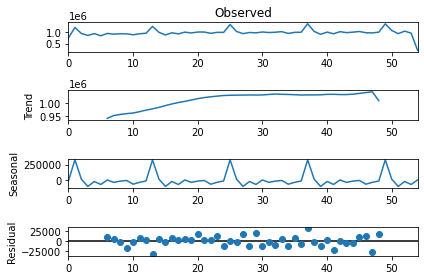

In [35]:
res = sm.tsa.seasonal_decompose(sales_for_decompose_month.values, freq = 12, model = "additive")

fig = res.plot()

fig.show()


**TRAFFIC**

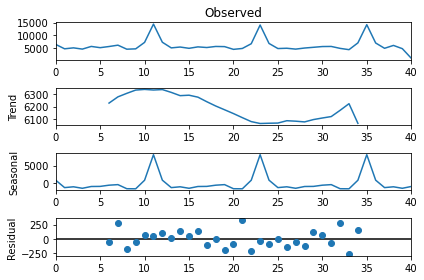

In [36]:
res = sm.tsa.seasonal_decompose(traffic_for_decompose_month.values, freq = 12, model = "additive")

fig = res.plot()

fig.show()

# Discussion

## General

What we see across almost every chart is clear and distinct seasonlity (this will be elaborated on below). What we also see, is that there is a quite a clear upwards trend (for the most part) in Sales across each chart (evidenced by the vertical differences between lines). This same trend is not necessarily seen across the charts for traffic. One explanation for this is that there are the obvious price pressures year on year in terms of inflation. This could explain why we see this trend in the average sales per hour, but not in the average traffic per hour.

This is clearly supported by the seasonal decompose done above this cell for both Sales and Traffic which clearly highlights the isolated Trend, Seasonality and Residuals for both Sales and Traffic (seperately) by month and across each datasets relative time horizon (in months). 

In fact in many of these charts one could argue that there are opposing trends in the sales per hour vs traffic per hour- also evidenced by seasonal decompose. If our sales data includes any online sales this could be made sense of.

## Sales and Traffic over Months of the Year

We can see from both charts that there is clear seasonality that persists through each year of available data, this insight is also supported by our trend cycle in our seasonal decompose.

We can therefore extablish that, evidenced by this seasonality, the month in which sales takes place has a large impact on what our average sales per hour has been in the past: eg Sales tend to be highest in the months of November, December and January. On top of this, this cycle has repeated itself across each year of our available data. So we know that the seasonlity is consistent and that the month of the year is important in terms of its relationship to average sales and traffic per hour.

## Sales and Traffic over Days of the Week

What we are seeing in these two charts is almost identical in nature to the above. There is clear 'seasonality' in terms of day of the week and average sales per hour. We see a trend that sales per hour increases later in the week and peaks on the weekend. This means that the day of the week is improtant in terms of its relationship to average sales and traffic per hour.

## Sales and Traffic over Hours of the Day

Our two charts here are practically identical. We see that sales per hour and traffic per hour tend to peak or be the highest between mid-day and mid-afternoon - and this is across each year of avaiable data for sales per hour and traffic per hour respectively. We can then surmise that the time of the day is important in terms of its relationship to sales and traffic per hour.

## Sales and Traffic over Time of the Month

Here things are slightly interesting. Judging by the prevailing trends in both sales per hour, and trraffic per hour across the 'time of the month', the 'time of the month' is an important feature. Although, we see very different trends in Sales and Traffic. 

As far as Sales per hour goes, the data would suggest (year on year) that the highest average sales per hour tends to happen in the middle of the month for the most part. After a bit of research this may make sense because the most common payment period in the USA are bi-monthly : on the 30th (previous month) and 15th (current month) of the month respectively. Consumers may use their first payday income (on the 30th) to pay for necessities (rent, finance costs, vehicle costs etc) and may use their second payday on the 15th of every month as disposable income for other items. (check: https://smallbusiness.chron.com/common-payroll-period-60915.html).

Conversely, average traffic per hour across different times of the month tells somewhat of a different story. There seems to be a positive linear relationship between the 'time of the month' and average traffic per hour.

Therefore, although they are different relationships, we are able to make the determination that the 'time of the month' is important in terms of its relationship to both average sales and average traffic per hour.

## Features

Now that we have made some observations about the data, we are much closer to being able top decide on important features to include in our model. As can be seen above we have very clear seasonality and trend across all charts for bothy sales and traffic per hour. We need to find a way to incorporate this trend and seasonlity into our data as features.

To handle the **SEASONALITY** we will:

- Use the month as a feature (using one-hot encoding)
- Use the day of the week as a feature (using one-hot encoding)
- Use the time of the day as a feature (using one-hot encoding)
- Use the 'time of the month' as a feature (using one-hot encoding)
- Ise whether the day is a public holiday or not as a feautre (using one-hot encoding)

To ensure that the **TREND** is captured in our data, we will use a 'lag' to capture the nature of the trend over time. So that this trend can be taken into account or understand by our model when making predictions. 

## Feature Engineering

In [37]:
sales.head(10)

,date,value,year,month,day_no,day,time,day_month,public_holiday?,month_cat
0,2013-11-07 13:00:00,3457,2013,November,7,Thursday,13,07 November,no,Month Beginning
1,2013-11-07 14:00:00,2250,2013,November,7,Thursday,14,07 November,no,Month Beginning
2,2013-11-07 15:00:00,0,2013,November,7,Thursday,15,07 November,no,Month Beginning
3,2013-11-07 16:00:00,729,2013,November,7,Thursday,16,07 November,no,Month Beginning
4,2013-11-07 17:00:00,0,2013,November,7,Thursday,17,07 November,no,Month Beginning
5,2013-11-07 18:00:00,1633,2013,November,7,Thursday,18,07 November,no,Month Beginning
6,2013-11-07 19:00:00,0,2013,November,7,Thursday,19,07 November,no,Month Beginning
7,2013-11-07 20:00:00,756,2013,November,7,Thursday,20,07 November,no,Month Beginning
8,2013-11-07 21:00:00,0,2013,November,7,Thursday,21,07 November,no,Month Beginning
9,2013-11-07 22:00:00,0,2013,November,7,Thursday,22,07 November,no,Month Beginning


In [38]:
def create_dummies(df, col_names):
    dummies = pd.get_dummies(df[col_names], prefix = col_names)
    df = pd.concat([df, dummies], axis = 1)
    for col in col_names:
        df.drop(col, axis =1, inplace = True)
    return df

the_col_names = ['month', 'day', 'time', 'public_holiday?', 'month_cat']

train_sales = create_dummies(sales, the_col_names)
train_traffic = create_dummies(traffic, the_col_names)


In [39]:
train_sales.columns ## checking dummies

Index(['date', 'value', 'year', 'day_no', 'day_month', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'time_00', 'time_01', 'time_02',
       'time_03', 'time_04', 'time_05', 'time_06', 'time_07', 'time_08',
       'time_09', 'time_10', 'time_11', 'time_12', 'time_13', 'time_14',
       'time_15', 'time_16', 'time_17', 'time_18', 'time_19', 'time_20',
       'time_21', 'time_22', 'time_23', 'public_holiday?_no',
       'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End'],
      dtype='object')

In [40]:
train_traffic.columns ## Checking dummies

Index(['date', 'value', 'year', 'day_no', 'day_month', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'time_00', 'time_01', 'time_02',
       'time_03', 'time_04', 'time_05', 'time_06', 'time_07', 'time_08',
       'time_09', 'time_10', 'time_11', 'time_12', 'time_13', 'time_14',
       'time_15', 'time_16', 'time_17', 'time_18', 'time_19', 'time_20',
       'time_21', 'time_22', 'time_23', 'public_holiday?_no',
       'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End'],
      dtype='object')

The above verifies that our one-hot encoding for the month, day, time, time_of_month and public holidays has been successfull. 

## 'Lagged' Variable

In order to capture the trend in the data, we are gooing to add a column with the previous years 'value' for the same hour of the same day of the same month as a feature. Unfortunately this means we will be discarding the first year of data - seeing as we do not have a value for the previousw year for this year. 

The easiest way to do this will be to filter our train sales dataset to not include the first year, create another dataset that is a lagged set (in terms of of value) for our filterted set and concatenate them.

In [41]:
train_sales = train_sales[8760:].reset_index()

prev_year_sales = sales[['date','value']]

prev_year_sales.columns = ['p_year_date', 'prev_year_value']

prev_year_sales = prev_year_sales[:-8760].reset_index()

train_sales = pd.concat([train_sales, prev_year_sales], axis = 1)


In [42]:
train_sales.columns

Index(['index', 'date', 'value', 'year', 'day_no', 'day_month', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'time_00', 'time_01', 'time_02',
       'time_03', 'time_04', 'time_05', 'time_06', 'time_07', 'time_08',
       'time_09', 'time_10', 'time_11', 'time_12', 'time_13', 'time_14',
       'time_15', 'time_16', 'time_17', 'time_18', 'time_19', 'time_20',
       'time_21', 'time_22', 'time_23', 'public_holiday?_no',
       'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End', 'index',
       'p_year_date', 'prev_year_value'],
      dtype='object')

In [43]:
columns = ['date', 'p_year_date', 'year', 'day_no', 'day_month', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'time_00', 'time_01', 'time_02',
       'time_03', 'time_04', 'time_05', 'time_06', 'time_07', 'time_08',
       'time_09', 'time_10', 'time_11', 'time_12', 'time_13', 'time_14',
       'time_15', 'time_16', 'time_17', 'time_18', 'time_19', 'time_20',
       'time_21', 'time_22', 'time_23', 'public_holiday?_no',
       'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End',
       'prev_year_value', 'value']

train_sales_original = train_sales
train_sales = train_sales[columns]

In [44]:
train_traffic = train_traffic[8760:].reset_index()

prev_year_traffic = traffic[['date','value']]

prev_year_traffic.columns = ['p_year_date', 'prev_year_value']

prev_year_traffic = prev_year_traffic[:-8760].reset_index()

train_traffic = pd.concat([train_traffic, prev_year_traffic], axis = 1)

In [45]:
columns = ['date', 'p_year_date', 'year', 'day_no', 'day_month', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'time_00', 'time_01', 'time_02',
       'time_03', 'time_04', 'time_05', 'time_06', 'time_07', 'time_08',
       'time_09', 'time_10', 'time_11', 'time_12', 'time_13', 'time_14',
       'time_15', 'time_16', 'time_17', 'time_18', 'time_19', 'time_20',
       'time_21', 'time_22', 'time_23', 'public_holiday?_no',
       'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End',
       'prev_year_value', 'value']

train_traffic_original = train_traffic
train_traffic = train_traffic[columns]

We will now normalize our previous years values to ensure that the previous years values are not given a disproportional weight when our model makes it's predictions:

In [46]:
train_sales['prev_year_value'] = (train_sales['prev_year_value'] -train_sales['prev_year_value'].min())/(train_sales['prev_year_value'].max()-train_sales['prev_year_value'].min())

train_traffic['prev_year_value'] = (train_traffic['prev_year_value'] -train_traffic['prev_year_value'].min())/(train_traffic['prev_year_value'].max()-train_traffic['prev_year_value'].min())

## Training

We will now go ahead and seperate our data into training and testing partitions. We train using the entire dataset in order to predict the last month for which we have data which is the month of 06th of April - 06th May (30 days). We know the values for this period so we will be able to determine how our model performs on unseen data.

In terms of the training process, we will train and cross-validate using two or three different models to determine which model best suits our needs according to the data. We will measure the performance of our model using Root Mean Sqaured Error (RMSE). This should give us an idea of how far off our predictions are on average - which is ideal as we will have a margin of error in which we can assume our model is accurate.

Let's begin by seperating out data:

In [47]:
## Let's drop some uneccessary columns that will not be used in training

train_sales.drop(['p_year_date', 'year', 'day_no', 'day_month'], inplace = True, axis = 1)
train_traffic.drop(['p_year_date', 'year', 'day_no', 'day_month'], inplace = True, axis = 1)

In [48]:
## Let us seperate our data into test and train, and keep our actual target column for comparison later
## There are 720 hours in a month (of 30 days)
## We will make this seperation for both our sales and traffic sets

sales_train = train_sales[:-720] ## All data except last month
sales_test = train_sales[29906:] ## Last month of Data
sales_test_actual = sales_test['value'] ## For comparing predictions to actual

traffic_train = train_traffic[:-720]  ## All data except last month
traffic_test = train_traffic[19831:]## Last month of Data
traffic_test_actual = traffic_test['value'] ## For comparing predictions to actual


Now we will take a look at our data to make sure the seperations worked and we have swegmented our data correctly:

In [49]:
sales_train.head(-5)

,date,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,...,time_21,time_22,time_23,public_holiday?_no,public_holiday?_yes,month_cat_Mid Month,month_cat_Month Beginning,month_cat_Month End,prev_year_value,value
0,2014-11-07 13:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.539903,3366
1,2014-11-07 14:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.351398,3149
2,2014-11-07 15:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.000000,3061
3,2014-11-07 16:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.113853,3172
4,2014-11-07 17:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.000000,3327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29901,2018-04-06 10:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.121037,2447
29902,2018-04-06 11:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.477745,3157
29903,2018-04-06 12:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.467906,3468
29904,2018-04-06 13:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.501484,3082


In [50]:
sales_test.head(-5) 

,date,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,...,time_21,time_22,time_23,public_holiday?_no,public_holiday?_yes,month_cat_Mid Month,month_cat_Month Beginning,month_cat_Month End,prev_year_value,value
29906,2018-04-06 15:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.530220,3304
29907,2018-04-06 16:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.370139,3170
29908,2018-04-06 17:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.252694,3149
29909,2018-04-06 18:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.484929,3146
29910,2018-04-06 19:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.471498,3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30621,2018-05-06 10:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.357020,0
30622,2018-05-06 11:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.502733,3503
30623,2018-05-06 12:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.545526,3404
30624,2018-05-06 13:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.548805,3915


In [51]:
traffic_train.head(-5)

,date,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,...,time_21,time_22,time_23,public_holiday?_no,public_holiday?_yes,month_cat_Mid Month,month_cat_Month Beginning,month_cat_Month End,prev_year_value,value
0,2016-01-01 10:00:00,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0.065574,7
1,2016-01-01 11:00:00,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0.114754,20
2,2016-01-01 12:00:00,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0.229508,32
3,2016-01-01 13:00:00,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0.270492,39
4,2016-01-01 14:00:00,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0.385246,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19826,2018-04-06 12:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.106557,21
19827,2018-04-06 13:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.073770,29
19828,2018-04-06 14:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.073770,34
19829,2018-04-06 15:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.131148,43


In [52]:
traffic_test.head(-5)

,date,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,...,time_21,time_22,time_23,public_holiday?_no,public_holiday?_yes,month_cat_Mid Month,month_cat_Month Beginning,month_cat_Month End,prev_year_value,value
19831,2018-04-06 17:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.122951,21
19832,2018-04-06 18:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.098361,14
19833,2018-04-06 19:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.081967,19
19834,2018-04-06 20:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0.040984,15
19835,2018-04-06 21:00:00,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20546,2018-05-06 12:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.237705,16
20547,2018-05-06 13:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.286885,49
20548,2018-05-06 14:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.303279,42
20549,2018-05-06 15:00:00,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0.295082,41


It looks like our data has been segmented properly. Each test set begins where the train set stopped, and we have 720 rows for each test set: therefore we have successfully seperated the last month (by hour obviously).

## Training and Cross-Validation Pipeline

We have created a pipeline that trains our models and performs cross_validation - outputting five scores for each instance of cross-validation. This should give us an idea of each our potential models performs on our training data. Before doing any sort of grid search or using any other mechanisms to optimize the paramters of our potential models, we will use these scores to determine what model would be the best to continue with (and to continue to optiomize) with regards to our data problem.

In [53]:
sales_train.columns

Index(['date', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September', 'day_Friday', 'day_Monday', 'day_Saturday',
       'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'time_00',
       'time_01', 'time_02', 'time_03', 'time_04', 'time_05', 'time_06',
       'time_07', 'time_08', 'time_09', 'time_10', 'time_11', 'time_12',
       'time_13', 'time_14', 'time_15', 'time_16', 'time_17', 'time_18',
       'time_19', 'time_20', 'time_21', 'time_22', 'time_23',
       'public_holiday?_no', 'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End', 'prev_year_value',
       'value'],
      dtype='object')

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

train_columns = ['month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September', 'day_Friday', 'day_Monday', 'day_Saturday',
       'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'time_00',
       'time_01', 'time_02', 'time_03', 'time_04', 'time_05', 'time_06',
       'time_07', 'time_08', 'time_09', 'time_10', 'time_11', 'time_12',
       'time_13', 'time_14', 'time_15', 'time_16', 'time_17', 'time_18',
       'time_19', 'time_20', 'time_21', 'time_22', 'time_23',
       'public_holiday?_no', 'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End', 'prev_year_value']

sales_train_features = sales_train[train_columns]
sales_train_target = sales_train['value']

traffic_train_features = traffic_train[train_columns]
traffic_train_target = traffic_train['value']

## We will now make a train, test and cross-validation pipeline:

def train(features, target, method):
    model = method.fit(features, target)
    return model

def test(model, test_features, test_target):
    rmse = []
    predictions = model.predict(test_features)
    accuracy = mean_squared_error(test_target, predictions)
    accuracy_val = np.sqrt(accuracy)
    rmse.append(accuracy_val)
    return rmse

def cross_validate(attributes, target, method):
    fold_accuracies = []
    kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
    for train_index, test_index in kf.split(attributes):
        train_features, test_features = attributes.iloc[train_index], attributes.iloc[test_index]
        test_labels, train_labels = target.iloc[test_index], target.iloc[train_index]
        model = train(train_features, train_labels, method)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

# Decision Tree Model

## Sales

In [55]:
dt = DecisionTreeRegressor()

decision_tree_model = cross_validate(sales_train_features, sales_train_target, dt)

decision_tree_model

[[511.267367313809],
 [505.14194886134084],
 [519.5808648550023],
 [543.4032948244695],
 [508.2499873447106]]

## Traffic

In [56]:
dt = DecisionTreeRegressor()

decision_tree_model = cross_validate(traffic_train_features, traffic_train_target, dt)

decision_tree_model

[[5.570765230129156],
 [5.983665205605718],
 [6.299052690561996],
 [6.10145110485734],
 [6.087526614460839]]

# Random Forest Model

## Sales

In [57]:
rfr = RandomForestRegressor()

random_forest_model = cross_validate(sales_train_features, sales_train_target, rfr)

random_forest_model

[[410.35063120963014],
 [400.50363409914115],
 [404.5203472821414],
 [435.2972567416736],
 [401.2579431374857]]

## Traffic

In [58]:
rfr = RandomForestRegressor()

random_forest_model = cross_validate(traffic_train_features, traffic_train_target, rfr)

random_forest_model

[[4.652548670097581],
 [4.617058204793081],
 [5.105496414481509],
 [5.064816550232927],
 [4.971321051357913]]

# Gradient Boosting Regressor

## Sales

In [59]:
gbr = GradientBoostingRegressor()

gbr_model = cross_validate(sales_train_features, sales_train_target, gbr)

gbr_model

[[464.9093261920039],
 [458.61959886743534],
 [454.2543486029278],
 [473.0740883077156],
 [459.0273181046789]]

## Traffic

In [60]:
gbr = GradientBoostingRegressor()

gbr_model = cross_validate(traffic_train_features, traffic_train_target, gbr)

gbr_model

[[5.679460146232165],
 [5.515490278424228],
 [5.489617703112292],
 [5.96371729254421],
 [5.728384154431966]]

# XGboost

## Sales

In [61]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', verbosity = 0, colsample_bytree = 0.3, learning_rate = 0.1)
        ## Some stanbdardzied values for the parameters

xgb_model = cross_validate(sales_train_features, sales_train_target, xg_reg)

xgb_model

[[489.3192868158419],
 [479.95441726651455],
 [469.29212279879175],
 [494.9706601616082],
 [486.207868257063]]

## Traffic

In [62]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', verbosity = 0, colsample_bytree = 0.3, learning_rate = 0.1)
        ## Some stanbdardzied values for the parameters

xgb_model = cross_validate(traffic_train_features, traffic_train_target, xg_reg)

xgb_model

[[6.302089344891468],
 [6.040740588701052],
 [6.145868631585279],
 [6.58127329012402],
 [6.365388284816142]]

# Linear Regression

## Sales

In [63]:
lr = LinearRegression()

lrm = cross_validate(sales_train_features, sales_train_target, lr)

lrm

[[517.0051048338744],
 [518.9548603836625],
 [511.8705838071128],
 [538.5300075968346],
 [527.7277941272334]]

## Traffic

In [64]:
lr = LinearRegression()

lrm = cross_validate(traffic_train_features, traffic_train_target, lr)

lrm

[[7.536559551294721],
 [7.226464008091568],
 [7.354824083593098],
 [7.790747587964703],
 [7.459693094462769]]

# Results

The above results are not surprising. Due to the categorical nature of much of the data (binary classfiers for whether it is a certain day, month, time of day or time of month), it is no surprise that a random forest model (which is a collection of decision trees) would perform well on this data, which it has - at least in comparison to the other approaches which were attempted.

**We must note the following with regards to the Random Forest Model:**
- The scores are quite similar across each of the four trenches for both sales and traffic respectively - meaning that our model performed consistently across the different tranches or cross-validation splits. This is good as it tells us that our model should perform similarly on unseen data.
- The scores are quite low - we expect to mispredict by on average in the regiion of 400 cents, and 5 'people' worth of traffic respectively. These RMSE scores are sgifnicantly lower than some of the competing algorithms.

The next step will be to see how our model performs on the 'unseen' test data. Once we have checked this we can look into making an attempt at optimizing our Random Forest Model's parameters in the hope that we can bring the test accuracys core down.

## Sales

In [65]:
sales_test_features = sales_test[train_columns]
traffic_test_features = traffic_test[train_columns]

rfr = RandomForestRegressor()

rfr.fit(sales_train_features, sales_train_target)

predictions_rfr = rfr.predict(sales_test_features)

accuracy_sales = mean_squared_error(sales_test_actual, predictions_rfr)

accuracy_val_sales = np.sqrt(accuracy_sales)

print('The RMSE is equal to: ' + str(accuracy_val_sales.round(2)))



The RMSE is equal to: 427.86


In order to chart our actual vs the predictions made by our model we will have to compress the data into daily segments so that there is enough space in our chart to clearly compare our predicted vs actual values. We will do the same for both sales and traffic.

**SALES COMPARISON: PREDICTED VS ACTUAL**

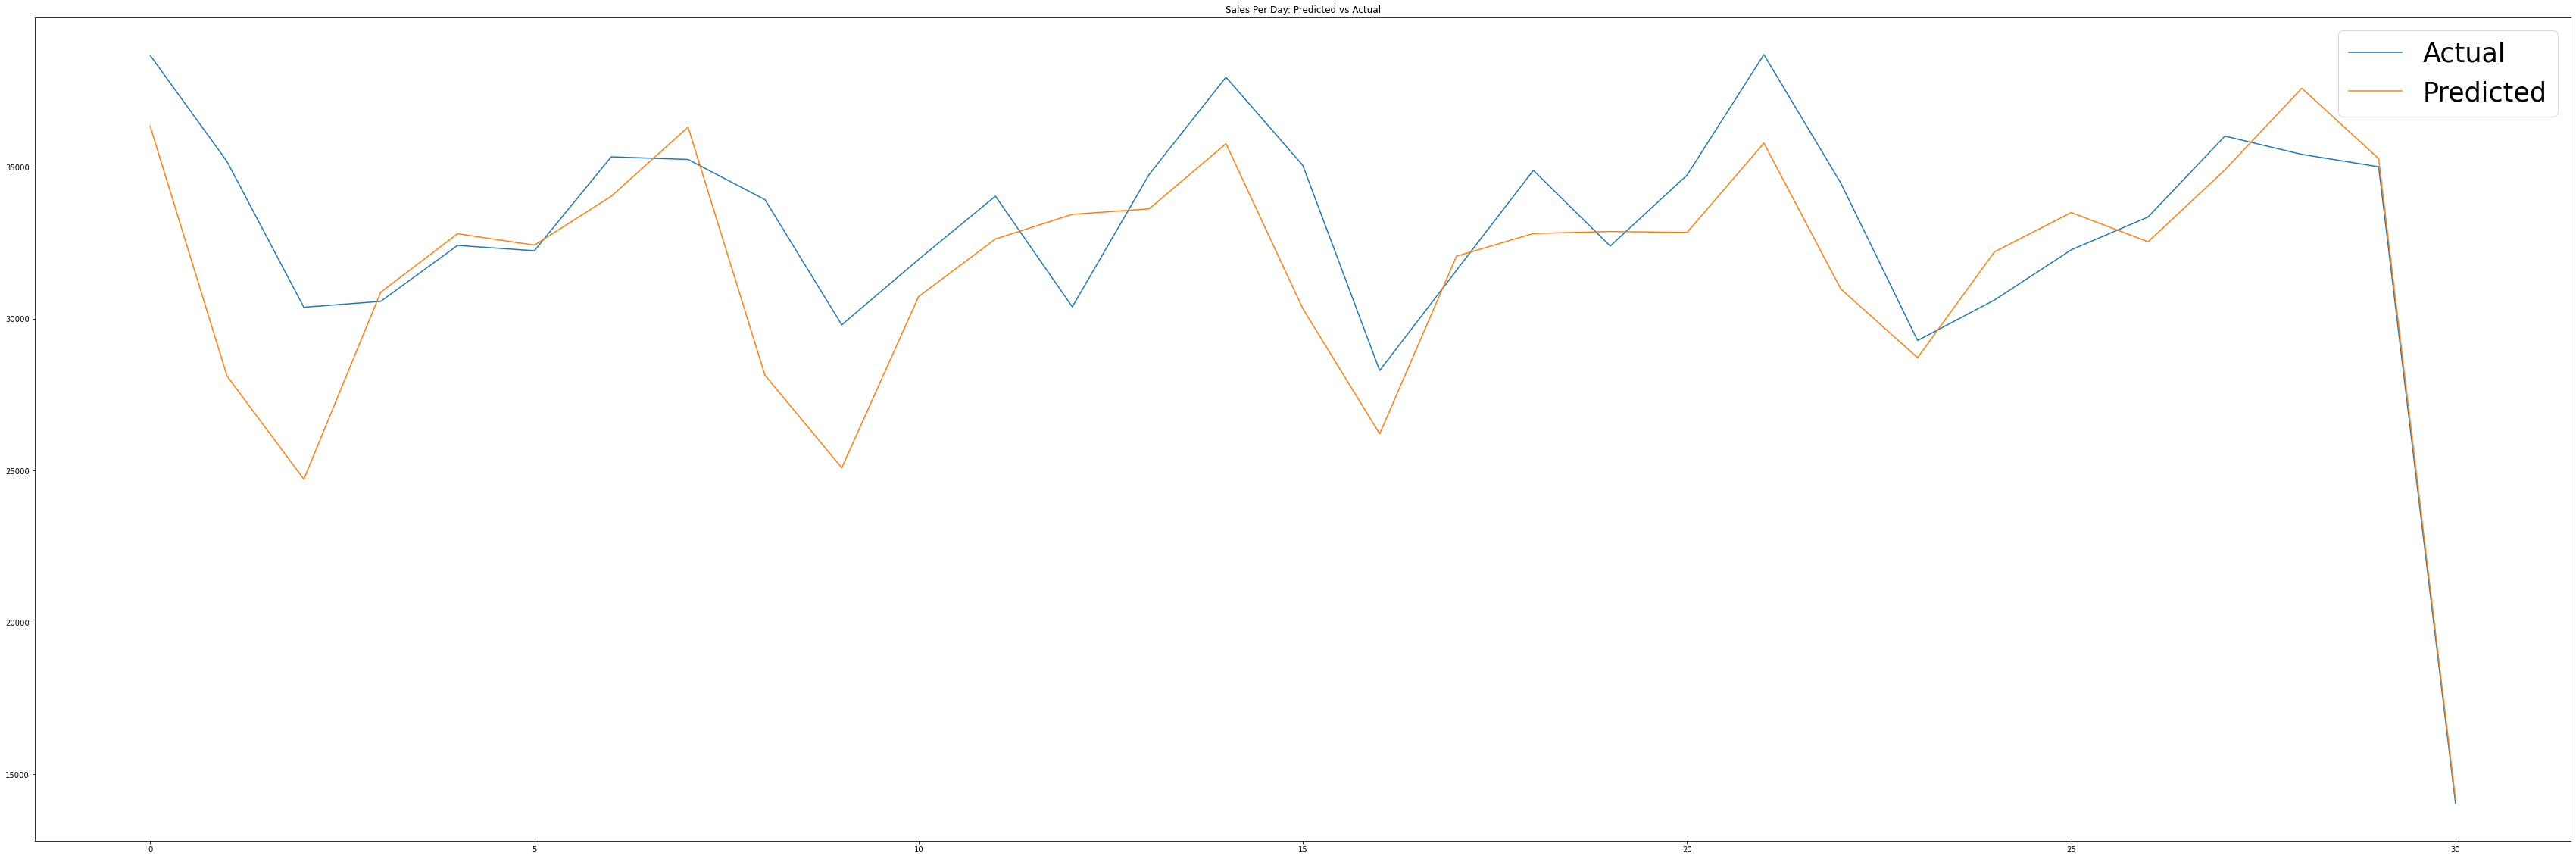

In [66]:
sales_test_actual.to_frame('sta')

pdf = pd.DataFrame(predictions_rfr, columns = ['predicted'])

sta = sales_test_actual.reset_index()
sta = sta['value']
sta.columns = ['actual']

comp_df = pd.concat([pdf, sta], axis =1)
comp_df.columns = ['predicted', 'actual']

## Getting sum of values for every 24 entries (24 hours in day)
## This is so that we can chart our results
comp_df = comp_df.groupby(comp_df.index // 24).sum() 

plt.figure(figsize = (60,20))
plt.title('Sales Per Day: Predicted vs Actual')
plt.plot(comp_df['actual'], label = 'Actual')
plt.plot(comp_df['predicted'], label = "Predicted")
plt.legend(prop = {'size': 35})

It looks like our model has identified the seasonality quite well as it it tends to follow the same general movements as our actual values - for the most part at least. 

An argument could be made that our model underpredicts our values per hour. If we know that the RMSE is 428.78, then you could possibly bear this in mind when making decisions based on these forecasts.

**FEATURE IMPORTANCE: SALES**

Feature: 0, Score: 0.00149
Feature: 1, Score: 0.00076
Feature: 2, Score: 0.00907
Feature: 3, Score: 0.00087
Feature: 4, Score: 0.00107
Feature: 5, Score: 0.00072
Feature: 6, Score: 0.00065
Feature: 7, Score: 0.00112
Feature: 8, Score: 0.00072
Feature: 9, Score: 0.00209
Feature: 10, Score: 0.00102
Feature: 11, Score: 0.00081
Feature: 12, Score: 0.00251
Feature: 13, Score: 0.00139
Feature: 14, Score: 0.00236
Feature: 15, Score: 0.02891
Feature: 16, Score: 0.00429
Feature: 17, Score: 0.00104
Feature: 18, Score: 0.00122
Feature: 19, Score: 0.00050
Feature: 20, Score: 0.00038
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00020
Feature: 25, Score: 0.00097
Feature: 26, Score: 0.00131
Feature: 27, Score: 0.00182
Feature: 28, Score: 0.00174
Feature: 29, Score: 0.02171
Feature: 30, Score: 0.00289
Feature: 31, Score: 0.00219
Feature: 32, Score: 0.00199
Feature: 33, Score: 0.00230
Feature: 34, Score: 0.00243
Feature: 35, Score: 0.00213
Fe

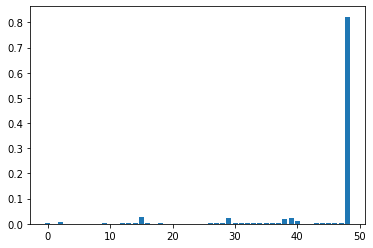

In [67]:
from matplotlib import pyplot

importance = rfr.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
 
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

It would appear that the feature that was the most important in predicting future values is the total sales per hour for the same date and time in the previous year. 

## Traffic

In [68]:
sales_test_features = sales_test[train_columns]
traffic_test_features = traffic_test[train_columns]

rfr = RandomForestRegressor()

rfr.fit(traffic_train_features, traffic_train_target)

predictions_rfr = rfr.predict(traffic_test_features)

accuracy_sales = mean_squared_error(traffic_test_actual, predictions_rfr)

accuracy_val_sales = np.sqrt(accuracy_sales)

print('The RMSE is equal to: ' + str(accuracy_val_sales.round(2)))

The RMSE is equal to: 3.46


**TRAFFIC COMPARISON: PRECIDTED VS ACTUAL**

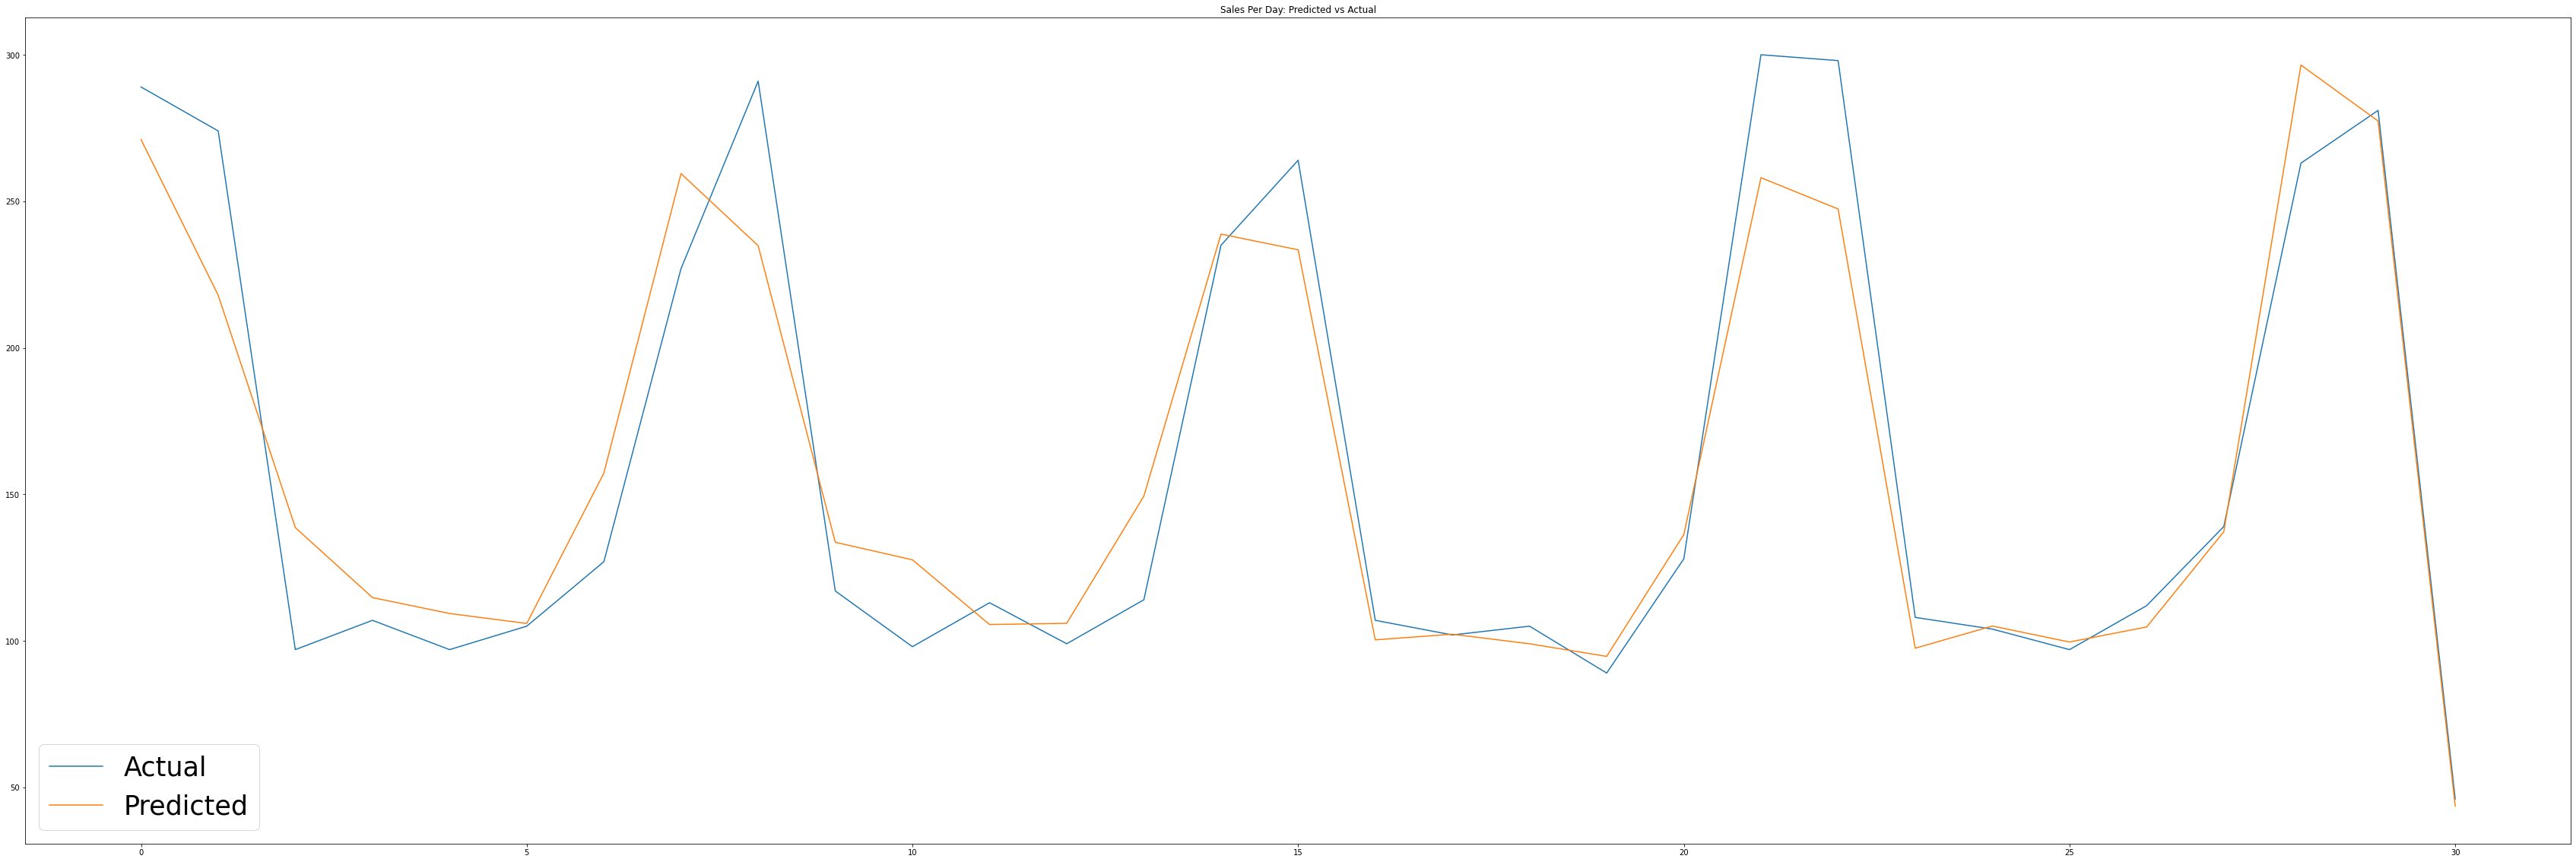

In [69]:
pdf_traffic = pd.DataFrame(predictions_rfr, columns = ['predicted'])

tta = traffic_test_actual.reset_index()
tta = tta['value']
tta.columns = ['actual']

comp_df_traffic = pd.concat([pdf_traffic, tta], axis =1)
comp_df_traffic.columns = ['predicted', 'actual']

## Getting sum of values for every 24 entries (24 hours in day)
## This is so that we can chart our results
comp_df_traffic = comp_df_traffic.groupby(comp_df_traffic.index // 24).sum() 

plt.figure(figsize = (60,20))
plt.title('Sales Per Day: Predicted vs Actual')
plt.plot(comp_df_traffic['actual'], label = 'Actual')
plt.plot(comp_df_traffic['predicted'], label = "Predicted")
plt.legend(prop = {'size': 35})

Our model for predicting traffic seems to have clearly captured the seasonality in our traffic dataset (even though we had a year and two months or so less data to work with). Although there is some clear variance between predicted and actual, our model should stiull be useful for forecasting expected traffic and ultimately going some way to forecasting demand.

**FEATURE IMPORTANCE: TRAFFIC**

Feature: 0, Score: 0.00275
Feature: 1, Score: 0.00155
Feature: 2, Score: 0.03313
Feature: 3, Score: 0.00244
Feature: 4, Score: 0.00567
Feature: 5, Score: 0.00230
Feature: 6, Score: 0.00240
Feature: 7, Score: 0.00369
Feature: 8, Score: 0.00185
Feature: 9, Score: 0.01374
Feature: 10, Score: 0.00298
Feature: 11, Score: 0.00180
Feature: 12, Score: 0.02675
Feature: 13, Score: 0.02112
Feature: 14, Score: 0.05912
Feature: 15, Score: 0.01220
Feature: 16, Score: 0.00213
Feature: 17, Score: 0.00479
Feature: 18, Score: 0.00134
Feature: 19, Score: 0.00026
Feature: 20, Score: 0.00024
Feature: 21, Score: 0.00015
Feature: 22, Score: 0.00014
Feature: 23, Score: 0.00002
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00150
Feature: 26, Score: 0.00230
Feature: 27, Score: 0.00212
Feature: 28, Score: 0.00264
Feature: 29, Score: 0.00772
Feature: 30, Score: 0.00807
Feature: 31, Score: 0.00744
Feature: 32, Score: 0.00880
Feature: 33, Score: 0.01152
Feature: 34, Score: 0.01259
Feature: 35, Score: 0.00866
Fe

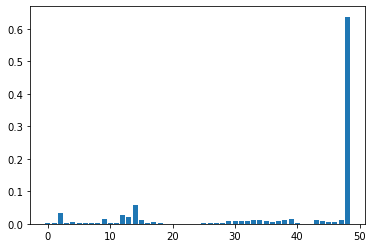

In [70]:
importance = rfr.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
 
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

As with the sales model, it seems that the most important feature in our traffic model is the traffic for the same period in the previous year.

In [71]:
train_sales_original.columns

Index(['index', 'date', 'value', 'year', 'day_no', 'day_month', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'time_00', 'time_01', 'time_02',
       'time_03', 'time_04', 'time_05', 'time_06', 'time_07', 'time_08',
       'time_09', 'time_10', 'time_11', 'time_12', 'time_13', 'time_14',
       'time_15', 'time_16', 'time_17', 'time_18', 'time_19', 'time_20',
       'time_21', 'time_22', 'time_23', 'public_holiday?_no',
       'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End', 'index',
       'p_year_date', 'prev_year_value'],
      dtype='object')

## Shop Closing Hours

As mentioned previously, the distribution of our data as it stands is skewed towards zero because of certain times of the day where there are no sales. We will now train and test a model that does not include these entries in the training data to determine if this can make our model more accurate.

For certain hours (02,03,04 and partially 05) there are no values for sales in the entire dataset - so we will create a seperate dataset for training and testing that does not include these values. We will then train, validate and test as above:

In [72]:
sales_chi[sales_chi['value'] == 0]['time'].value_counts()

02    1641
03    1641
04    1641
05    1640
01    1639
06    1636
00    1636
07    1621
23    1618
08    1579
22    1552
09    1391
21     642
20     240
10     201
19      92
18      25
17      20
14      20
15      20
11      19
12      19
13      19
16      19
Name: time, dtype: int64

As can be seen above there are no values for the times of: 02,03,04. We can see below also that there is only one value for the time of '05' and only two values greater than zero for the time of '01' - as such these are outliers in the context of our 'closing hours not included' dataset and as such will be removed. See below:

In [73]:
sales_chi[(sales_chi['time'] == '01') & (sales_chi['value'] > 0)]

,date,value,year,month,day_no,day,time,day_month,public_holiday?,month_cat
1092,2013-12-23 01:00:00,1653,2013,December,23,Monday,01,23 December,no,Month End
18636,2015-12-24 01:00:00,4030,2015,December,24,Thursday,01,24 December,yes,Month End


In [74]:
sales_chi[(sales_chi['time'] == '05') & (sales_chi['value'] > 0)]

,date,value,year,month,day_no,day,time,day_month,public_holiday?,month_cat
9256,2014-11-28 05:00:00,2775,2014,November,28,Friday,05,28 November,no,Month End


In [75]:
## Let's remove all 'closing hours' : 01,02,03,04,05

times = ['01', '02', '03', '04', '05']

for time in times:
    sales_chi = sales_chi[sales_chi['time'] != time]


the_col_names = ['month', 'day', 'time', 'public_holiday?', 'month_cat']

train_sales_chi = create_dummies(sales_chi, the_col_names)

In [76]:
## Add a lagged Variable Again (create col with sales for same time in previous year)

train_sales_chi = train_sales_chi[6935:].reset_index() ## 8760 hours in a year less the removed 5 hours per day: 1825

prev_year_sales_chi = sales_chi[['date','value']]

prev_year_sales_chi.columns = ['p_year_date', 'prev_year_value']

prev_year_sales_chi = prev_year_sales_chi[:-6935].reset_index()

train_sales_chi = pd.concat([train_sales_chi, prev_year_sales_chi], axis = 1)

train_sales_chi[['date', 'p_year_date']].head(5) 
## to verify that we have the correct 'prev_year_values' i.e that the dates match

,date,p_year_date
0,2014-11-07 13:00:00,2013-11-07 13:00:00
1,2014-11-07 14:00:00,2013-11-07 14:00:00
2,2014-11-07 15:00:00,2013-11-07 15:00:00
3,2014-11-07 16:00:00,2013-11-07 16:00:00
4,2014-11-07 17:00:00,2013-11-07 17:00:00


In [77]:
## Let's normalize previous years values:

train_sales_chi['prev_year_value'] = (train_sales_chi['prev_year_value'] -train_sales_chi['prev_year_value'].min())/(train_sales_chi['prev_year_value'].max()-train_sales_chi['prev_year_value'].min())

In [78]:
train_columns = ['month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September', 'day_Friday', 'day_Monday', 'day_Saturday',
       'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'time_00','time_06',
       'time_07', 'time_08', 'time_09', 'time_10', 'time_11', 'time_12',
       'time_13', 'time_14', 'time_15', 'time_16', 'time_17', 'time_18',
       'time_19', 'time_20', 'time_21', 'time_22', 'time_23',
       'public_holiday?_no', 'public_holiday?_yes', 'month_cat_Mid Month',
       'month_cat_Month Beginning', 'month_cat_Month End', 'prev_year_value']

sales_chi_train_features = train_sales_chi[train_columns]
sales_chi_train_target = train_sales_chi['value']

In [79]:
rfr_chi = RandomForestRegressor()

random_forest_model_chi = cross_validate(sales_chi_train_features, sales_chi_train_target, rfr_chi)

random_forest_model_chi

[[456.3250612825427],
 [444.0707420179925],
 [439.5728729451074],
 [456.97346960993434],
 [471.0908837767796]]

Looking at our cross-validation scores, it seems that our model performed better when we included the zero values. As such we will take the case of 'closed hours' no further.

## Hyperparamter Tuning

Seeing as the RandomForestRegressor was our best performing model, we will see if we can further optmize it by tuning the hyperparameters of the model (which are all default at this point in time) to determine if this can translate into more predictive accuracy/power.

To do this we will use GridSearchCV:


In [81]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]}

rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = params, 
                                n_iter = 100, cv = 4, verbose = 2, random_state = 2,
                                n_jobs = -1)

rfr_random.fit(sales_train_features, sales_train_target)




Fitting 4 folds for each of 45 candidates, totalling 180 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_features': ['sqrt', 0.25, 0.5,
                                                         0.75, 1.0],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [50, 150, 250]},
                   random_state=2, verbose=2)

[CV] END max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=150; total time=   6.6s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=250; total time=  11.0s
[CV] END max_features=sqrt, min_samples_split=4, n_estimators=50; total time=   2.4s
[CV] END max_features=sqrt, min_samples_split=4, n_estimators=150; total time=   7.0s
[CV] END max_features=sqrt, min_samples_split=4, n_estimators=250; total time=  10.8s
[CV] END max_features=sqrt, min_samples_split=6, n_estimators=50; total time=   2.0s
[CV] END max_features=sqrt, min_samples_split=6, n_estimators=150; total time=   5.5s
[CV] END max_features=sqrt, min_samples_split=6, n_estimators=250; total time=   8.9s
[CV] END max_features=0.25, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END max_features=0.25, min_samples_split=2, n_estimators=150; total time=   8.1s
[CV] END max_features=0.25, min_samples_split=2, n_estimat

In [82]:
rfr_random.best_params_

{'n_estimators': 250, 'min_samples_split': 6, 'max_features': 'sqrt'}

In [84]:
rfr = RandomForestRegressor(n_estimators = 250, min_samples_split = 6,
                            max_features = 'sqrt')

rfr.fit(sales_train_features, sales_train_target)

predictions_rfr = rfr.predict(sales_test_features)

accuracy_sales = mean_squared_error(sales_test_actual, predictions_rfr)

accuracy_val_sales = np.sqrt(accuracy_sales)

print('The RMSE is equal to: ' + str(accuracy_val_sales.round(2)))


The RMSE is equal to: 343.82


In [86]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]}

rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = params, 
                                n_iter = 100, cv = 4, verbose = 2, random_state = 2,
                                n_jobs = -1)

rfr_random.fit(traffic_train_features, traffic_train_target)


Fitting 4 folds for each of 45 candidates, totalling 180 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_features': ['sqrt', 0.25, 0.5,
                                                         0.75, 1.0],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [50, 150, 250]},
                   random_state=2, verbose=2)

In [87]:
rfr_random.best_params_

{'n_estimators': 250, 'min_samples_split': 2, 'max_features': 'sqrt'}

In [89]:
rfr = RandomForestRegressor(n_estimators = 250, min_samples_split = 2,
                            max_features = 'sqrt')

rfr.fit(traffic_train_features, traffic_train_target)

predictions_rfr = rfr.predict(traffic_test_features)

accuracy_sales = mean_squared_error(traffic_test_actual, predictions_rfr)

accuracy_val_sales = np.sqrt(accuracy_sales)

print('The RMSE is equal to: ' + str(accuracy_val_sales.round(2)))

The RMSE is equal to: 3.21


By optimizing our hyperparameters we have been able to improve our RMSE for both our traffic and sales test sets.

Before optimization they had values of 427.86 and 3.46 respectively.

Through the optimization of the hyperparamters we have been able to reduce the RMSE for both the sales and traffic test sets to **343.82** and **3.21** respectively.

We can therefore say our hyperparameter optmization yielded very positive results.

## Conclusion

As far as forecasting possible demand using our sales and traffic data, we have found that the best model to use would be the RandomForest model. And we have seen how it, most accurately in the context of its competing models, is able to apply known trend and seasonaility to arrive at quite accurate forecasting for our test month - with an RMSE of only  and 3.47 for sales and traffic respectively.

This means that our model may mispredict our sales and traffic by only 427.86 cents and 3 people respectively - this is not bad if the main use of the model is use demand forecasting to purchase the right amounts of stock, ensure there are enough employees to satisfy customers etc.
